**DATA CHALLENGE - ANOMALY DETECTION**

For this challenge, I've chosen first to perform some basic analysis to understand the data. This analysis consists of displaying train/test data in order to spot the differences. This allowed me to draw conclusions on the difference of both datasets e.g. the presence of outliers, standardization, stationarity,... and to have a first idea of interesting features to use for the future of my work.

Then, I tried a large number of different algorithms. It turns out that simple Feature Engineering worked the best. I thus focused on this method using the best features as possible. Important to note that the package *tsfresh* brought significant value to my research.

DATA EXPLORATION

<a href="#data_exploration">Data exploration</a>

<br>

ANOMALY DETECTION

<a href="#pca">PCA</a>

<a href="#pca_neighbors">PCA + LOF</a>

<a href="#stationarity">Stationarity</a>

<a href="#autoencoders">Autoencoders</a>

<a href="#lstm">LSTM</a>

<a href="#score_averaging">Score averaging</a>

<a href="#pca_isolation_forests">PCA + Isolation Forests</a>

<a href="#autoencoder_lof">Autoencoder + LOF</a>

<a href="#autoencoder_isolation_forests">Autoencoder + Isolation Forests</a>

<a href="#feature_engineering_if">Feature engineering + Isolation Forests</a>

<a href="#feature_engineering_lof">Feature engineering + LOF</a>

<a href="#data_generation_noise">Data Generation (noise)</a>

<a href="#mastering_feature_extraction">Mastering feature extraction</a>

<a href="feature_extraction_binary">Introduction binary variables for feature extraction</a>



<br>
<br>

Shortcut: <a href="#display_anomalies">Display anomalies</a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import random as random
import time
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Load data (train data)**

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
train_file = 'https://drive.google.com/open?id=1Qdc65IzOuJTIrBbb8gXm4z9NOCqrqvTp'
fluff, id_train = train_file.split('=')
test_file = 'https://drive.google.com/open?id=1KQTL1Mx3vUSkJMXDMARw6Z5aA12deMVi'
fluff, id_test = test_file.split('=')

start_time = time.time()
downloaded = drive.CreateFile({'id':id_train})
downloaded.GetContentFile('airbus_train.csv')

data = np.loadtxt('airbus_train.csv', delimiter= ' ')
print("{} seconds".format(round(time.time() - start_time,2)))

start_time = time.time()
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('airbus_test.csv') 

data_test = np.loadtxt('airbus_test.csv', delimiter= ' ')
print("{} seconds".format(round(time.time() - start_time,2)))

108.39 seconds
176.08 seconds


Loading using pandas seems to be slightly longer.

Using Collab:
- 2 mins full loading

Using local:
- Test 1: crash
- Test 2: 57s full loading

In [0]:
def displayObservation(i, data_to_use):
  fig = plt.figure(figsize=(40,5))
  plt.plot(range(data_to_use.shape[1]),data_to_use[i,:])

**Data exploration**

<a name="data_exploration">ref:data_exploration</a>

*Graphs (train data)*

Text(0.5, 1.0, 'Observations for the 5 first entries')

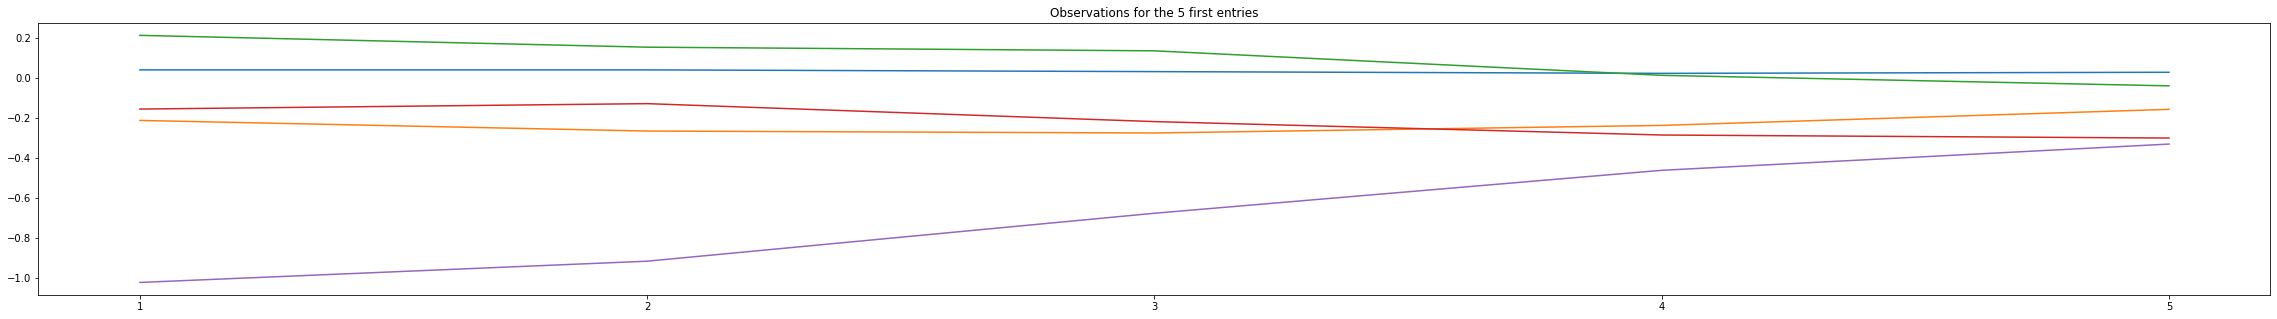

In [0]:
ax = plt.figure(figsize=(40,5)).gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

for i in range(5):
    plt.plot(range(1,6),data[i,:5])
plt.title('Observations for the 5 first entries')

Curves can have all different trends (ascending, descending, steady).

Text(0.5, 1.0, 'Observations for random entries')

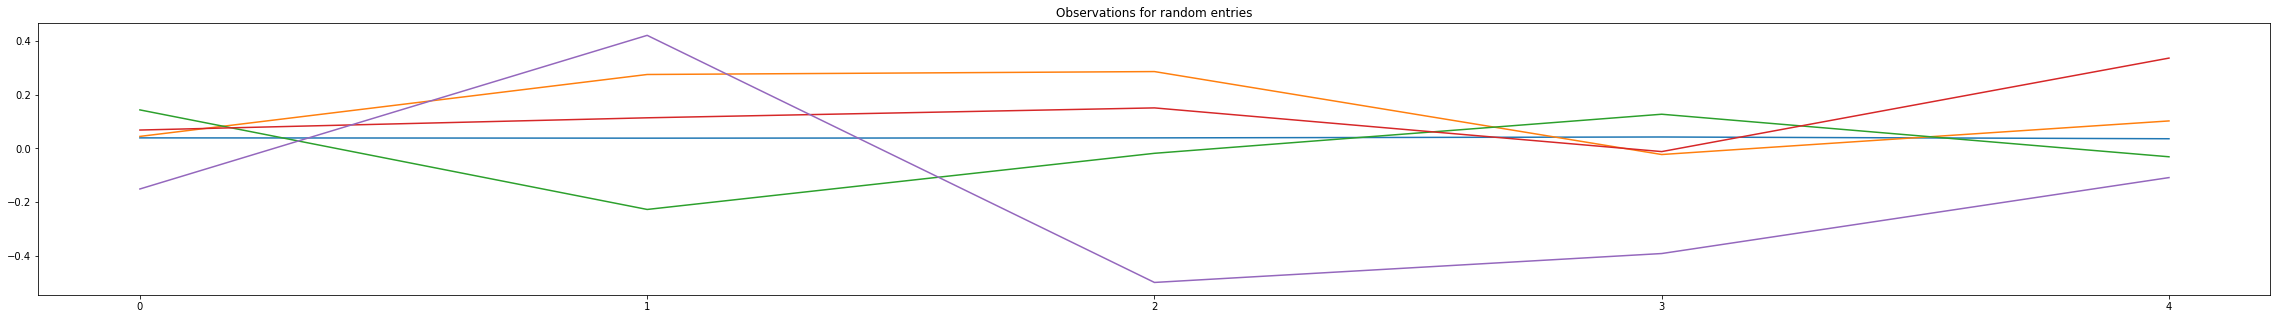

In [0]:
ax = plt.figure(figsize=(40,5)).gca()
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

rdmIdx = []
for i in range(5):
    rdmIdx.append(int(random.random()*1024))
for i in range(5):
    cycles = []
    for idx in rdmIdx:
        cycles.append(data[i,idx])
    plt.plot(range(5), cycles)
plt.title('Observations for random entries')

Higher volatility using random cycles => cycles in one minute seem to be ordered.

=> **autocorrelation** might be a good feature

Text(0.5, 1.0, 'last observations for the last 10 entries')

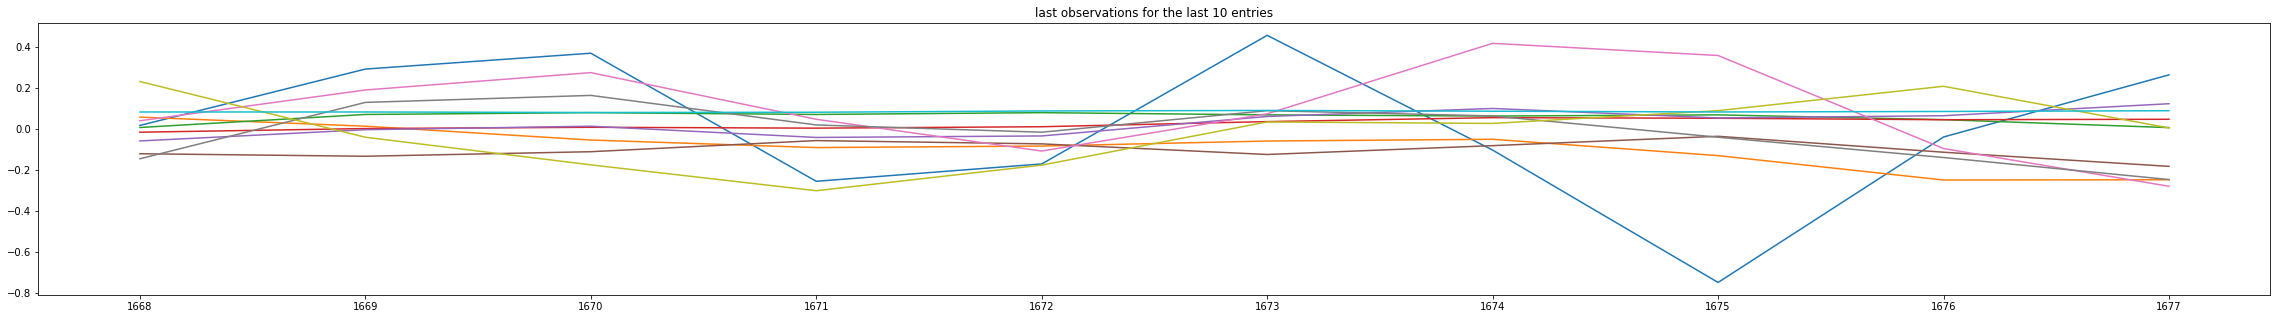

In [0]:
ax = plt.figure(figsize=(40,5)).gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator())

r,c = np.shape(data)
for i in range(r-10,r):
    plt.plot(range(r-9,r+1),data[i,c-10:c])
plt.title('last observations for the last 10 entries')

Same conclusion as before.

We also notice that the mean seems to be at zero.

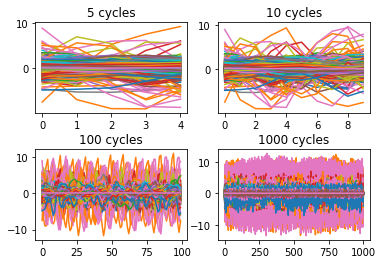

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=2)
X = [ (0,0,5), (0,1,10), (1,0,100), (1,1,1000) ]
for nrows, ncols, param in X:
    data_col = param
    for i in range(len(data)):
        ax[nrows, ncols].plot(range(data_col),data[i,:data_col])
    ax[nrows, ncols].set_title(str(data_col) + ' cycles')
plt.subplots_adjust(hspace = 0.4)

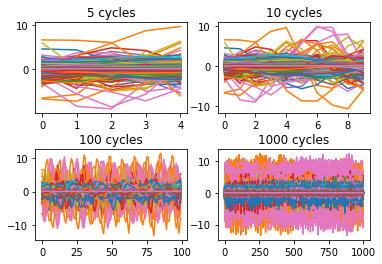

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=2)
X = [ (0,0,5), (0,1,10), (1,0,100), (1,1,1000) ]
for nrows, ncols, param in X:
    data_col = param
    for i in range(len(data)):
        ax[nrows, ncols].plot(range(data_col),data[i,1024:1024+data_col])
    ax[nrows, ncols].set_title(str(data_col) + ' cycles')
plt.subplots_adjust(hspace = 0.4)

Displaying different number of cycles for 2d time second gives a magnitude seems slightly higher.

*Graphs (test data)*

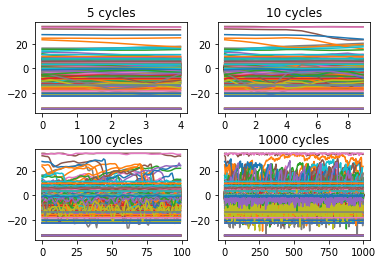

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=2)
X = [ (0,0,5), (0,1,10), (1,0,100), (1,1,1000) ]
for nrows, ncols, param in X:
    data_col = param
    for i in range(len(data_test)):
        ax[nrows, ncols].plot(range(data_col),data_test[i,:data_col])
    ax[nrows, ncols].set_title(str(data_col) + ' cycles')
plt.subplots_adjust(hspace = 0.4)

Standardization is much less obvious than for the train set!

Let's display random observations from the test set.

562
2230
2400
337
2035
0.13 seconds


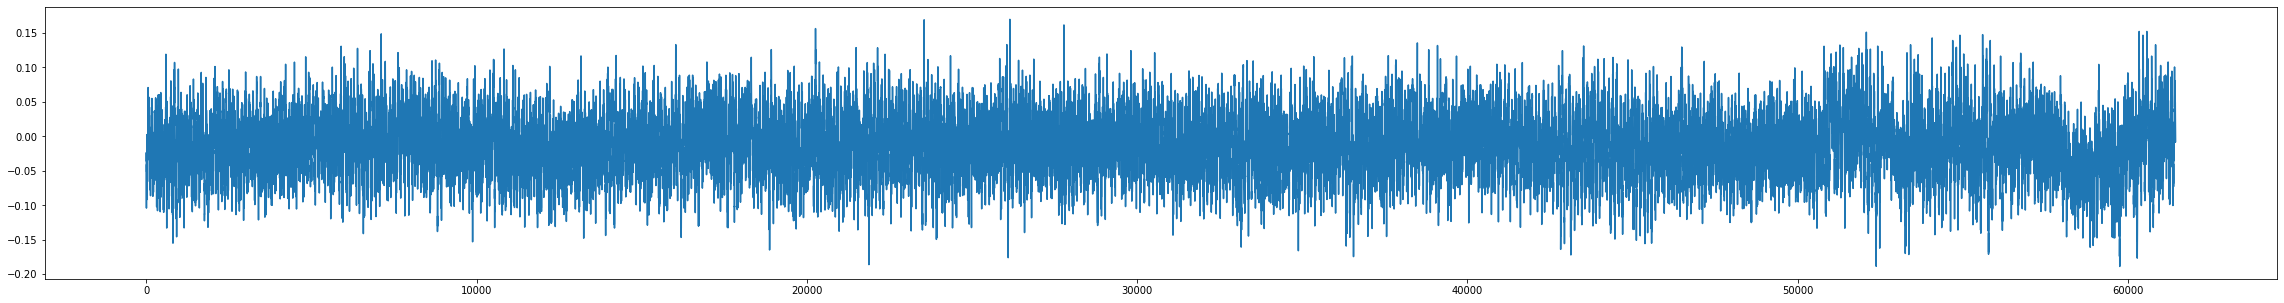

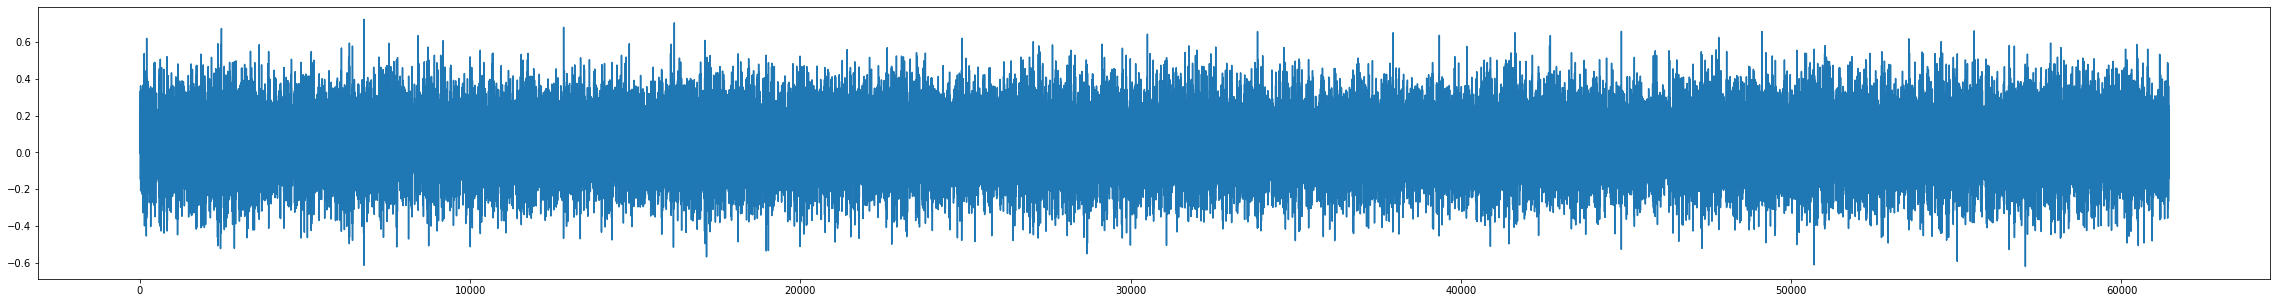

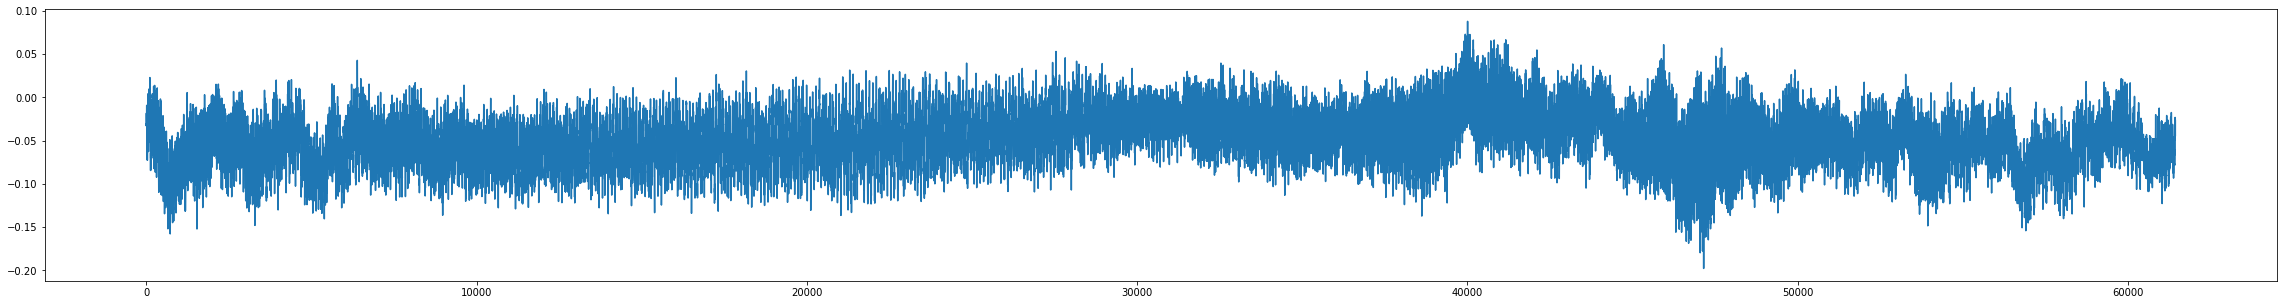

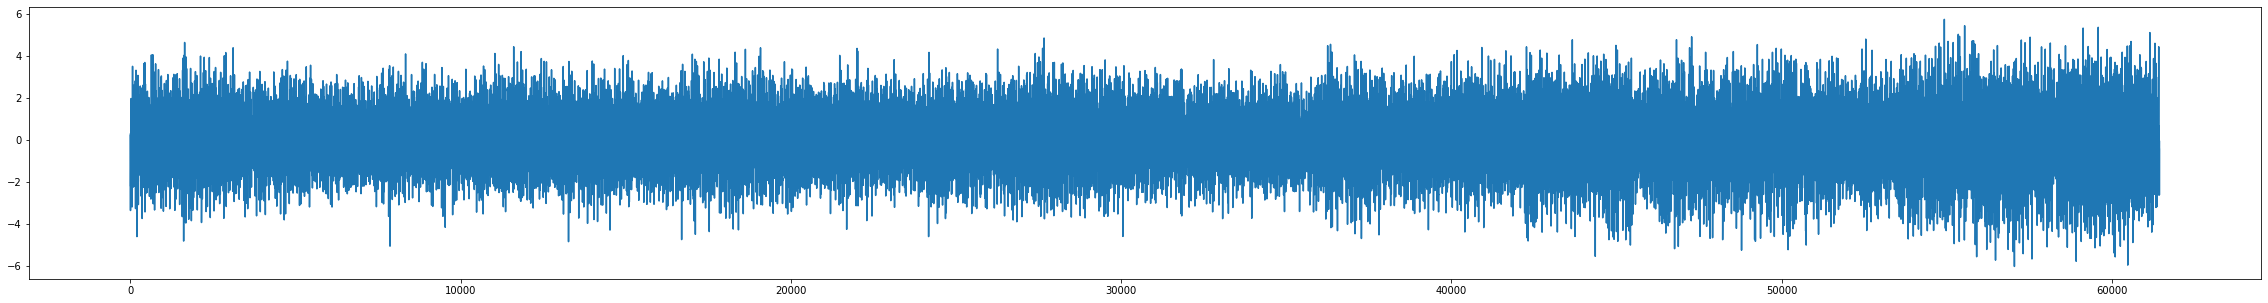

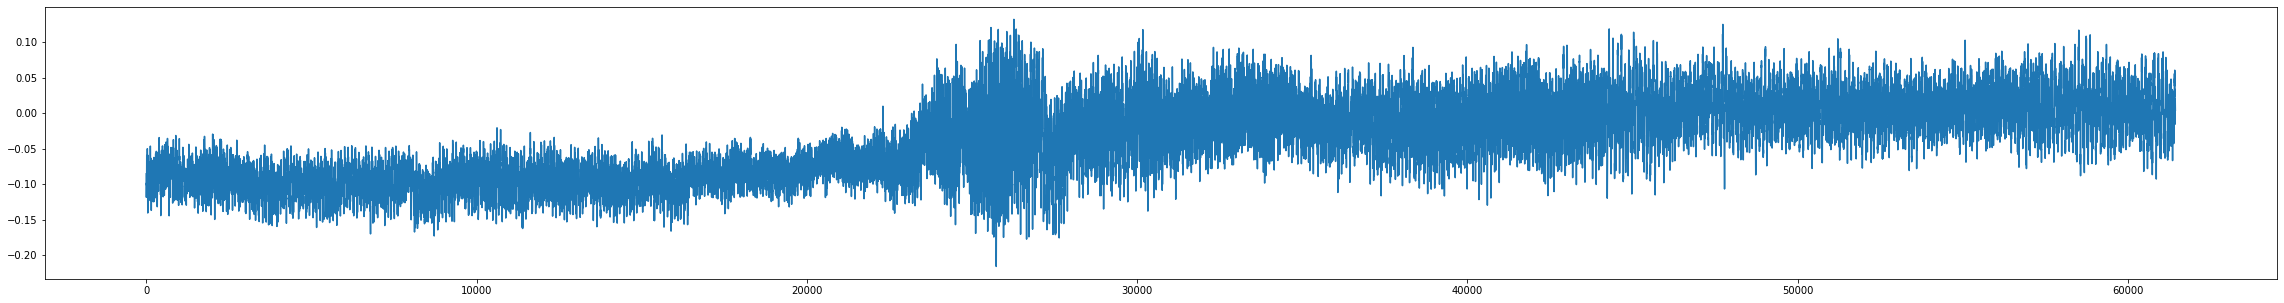

In [0]:
start_time = time.time()
random_state_list = [59,46,2,1,899]
for s in random_state_list:
  random.seed(s)
  n = int(random.random()*data_test.shape[0])
  print(n)
  fig = plt.figure(figsize=(40,5))
  plt.plot(range(data.shape[1]),data_test[n,:])
print("{} seconds".format(round(time.time() - start_time,2)))

Observations at index 2400 and 2035 are less stationary => outliers? If yes, we could measure the **stationarity**: the more non-stationary it is, the more likely it is an outlier.

*Standardization*

Standardized variables ?

- It has to be the case before PCA (so that we look for eigenvectors of the correlation matrix)
- Important when variables do not have the same unit measure ("variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bias")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


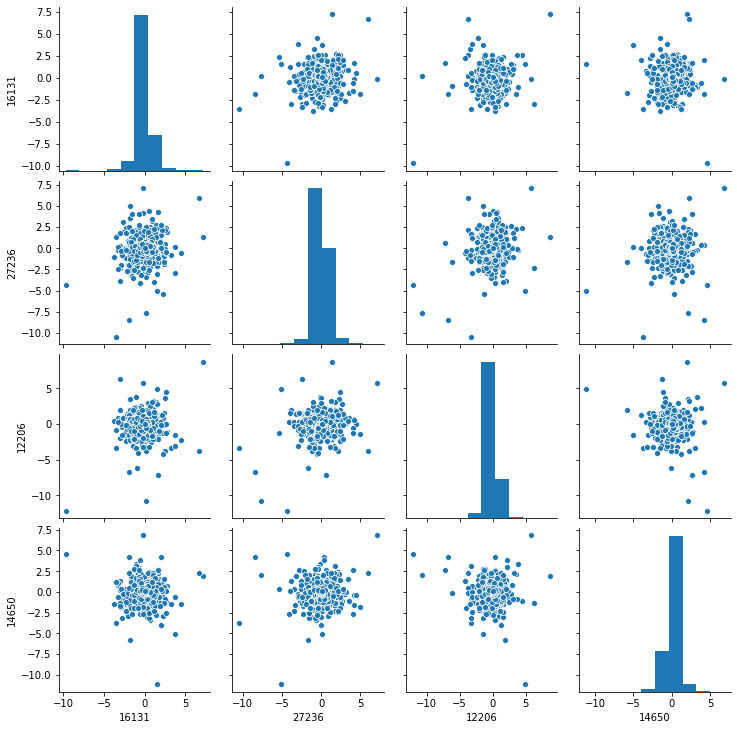

In [0]:
df = pd.DataFrame()
data_df = pd.DataFrame(data)
data_sample = data_df.sample(n=4, random_state=11, axis=1)
sns.pairplot(data_sample, size=2.5)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


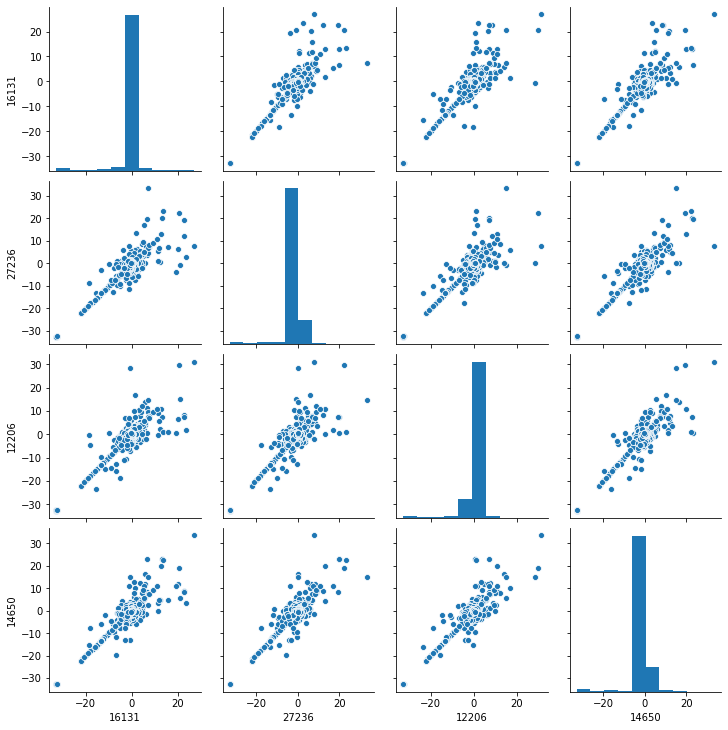

In [0]:
df = pd.DataFrame()
data_df = pd.DataFrame(data_test)
data_sample = data_df.sample(n=4, random_state=11, axis=1)
sns.pairplot(data_sample, size=2.5)

We confirm data are centered and a possible presence of outliers in the test set.

=> Variance very close to one.

ALL STATS

In [0]:
data_df.describe()

0            1      ...        61438        61439
count  1677.000000  1677.000000  ...  1677.000000  1677.000000
mean     -0.000664    -0.003480  ...     0.023029     0.021341
std       0.883526     0.835984  ...     0.878701     0.937541
min      -7.496269    -6.943695  ...    -5.582950    -7.378208
25%      -0.289418    -0.275076  ...    -0.269485    -0.266519
50%       0.010897     0.009686  ...     0.013833     0.010897
75%       0.246873     0.253578  ...     0.270694     0.258418
max       8.915436     6.995956  ...     8.585596     9.847754

[8 rows x 61440 columns]

In [0]:
pd.DataFrame(data_test).describe()

0            1      ...        61438        61439
count  2511.000000  2511.000000  ...  2511.000000  2511.000000
mean     -0.619991    -0.632000  ...    -0.655068    -0.656215
std       4.706366     4.707120  ...     4.769044     4.765991
min     -32.771890   -32.796411  ...   -32.781698   -32.779246
25%      -0.144995    -0.155199  ...    -0.152033    -0.152421
50%      -0.007535    -0.007678  ...    -0.006821    -0.006063
75%       0.095331     0.095498  ...     0.091791     0.093384
max      34.015848    34.015848  ...    34.015848    34.015848

[8 rows x 61440 columns]

***Variables seem to be standardized***

*PCA (train data)*

In [0]:
start_time = time.time()
pca = PCA(n_components = 2, whiten = True)
data_reduced = pca.fit_transform(data)
print("{} seconds".format(round(time.time() - start_time,2)))

3.4 seconds


Text(0.5, 1.0, 'PCA on all set (2 components)')

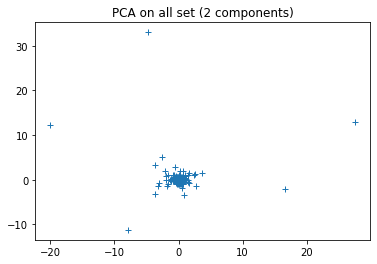

In [0]:
plt.plot(data_reduced[:,0],data_reduced[:,1], '+')
plt.title('PCA on all set (2 components)')

Reduced data don't seem to be linearly separable.

Outliers seem to be significantly different.

In [0]:
pca.explained_variance_ratio_ # eigenvalues of each component / sum of eigenvalues

array([0.04309328, 0.03823463])

Very low amount of variance are explained by the first 2 components.

In [0]:
start_time = time.time()
pca_10 = PCA(n_components = 10)
data_reduced_10 = pca_10.fit_transform(data)
print("{} seconds".format(round(time.time() - start_time,2)))

3.81 seconds


In [0]:
pca_10.explained_variance_ratio_

array([0.04309328, 0.03823463, 0.03242213, 0.02724604, 0.02648383,
       0.02601771, 0.02292857, 0.02137939, 0.01987789, 0.01828728])

In [0]:
np.sum(pca_10.explained_variance_ratio_)

0.2759707412659316

27% of the variance are explained by the 10 components.

In [0]:
start_time = time.time()
pca_100 = PCA(n_components = 100)
data_reduced_full = pca_100.fit_transform(data)
print("{} seconds".format(round(time.time() - start_time,2)))

10.31 seconds


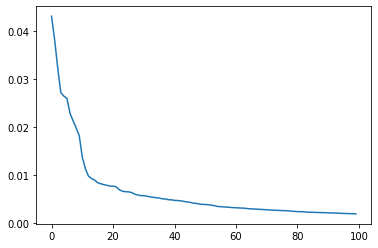

In [0]:
plt.plot(range(100),pca_100.explained_variance_ratio_)

We can see that the 20 first components explain the best the variance.

*PCA (test_data)*

In [0]:
start_time = time.time()
pca_test_2 = PCA(n_components = 2, whiten = True)
data_test_reduced = pca_test_2.fit_transform(data_test)
print("{} seconds".format(round(time.time() - start_time,2)))

5.06 seconds


Text(0.5, 1.0, 'PCA on all set (2 components)')

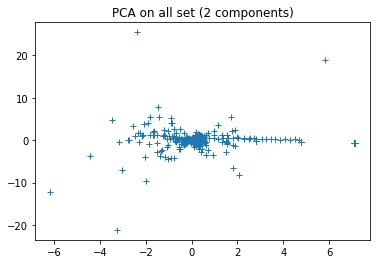

In [0]:
plt.plot(data_test_reduced[:,0],data_test_reduced[:,1], '+')
plt.title('PCA on all set (2 components)')

Quite obvious there are more outliers (compared with train data).

In [0]:
pca_test_10 = PCA(n_components = 10, whiten = True)
data_test_reduced_10 = pca_test_10.fit_transform(data_test)
pca_test_10.explained_variance_ratio_

array([0.91593717, 0.01113176, 0.0042155 , 0.00323645, 0.00200121,
       0.00194055, 0.00147036, 0.00142688, 0.00135112, 0.00124064])

First component explains 91.6% of the variance!!

**PCA (1)**

Since the PCA components represent the variance, ce can perform a first basic detection using a one-component pca as a score.

<a name="pca">ref:pca</a>

In [0]:
data_test_first_component = data_test_reduced_10[:,0]

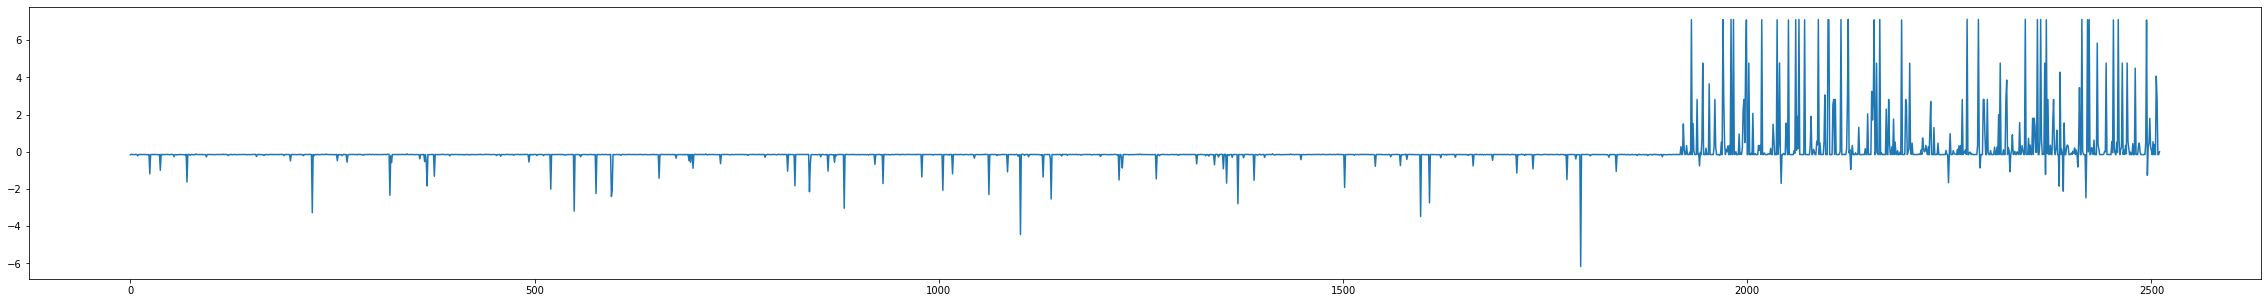

In [0]:
fig = plt.figure(figsize=(40,5))
plt.plot(range(data_test.shape[0]),data_test_first_component)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_anomaly_pca1.csv', data_test_first_component, fmt = '%1.6f', delimiter=',')

Score 0.615951030195 (16/24) - 17/04

**PCA (20) + Neighbors**

As seen previously, we will first try to catch a good amount of the variance using 20 components.

<a name="pca_neighbors">ref:pca_neighbors</a>

In [0]:
start_time = time.time()
pca_20 = PCA(n_components = 20)
data_reduced_20 = pca_20.fit_transform(data)
print("{} seconds".format(round(time.time() - start_time,2)))

4.33 seconds


In [0]:
np.sum(pca_20.explained_variance_ratio_)

0.3699293088830734

Text(0.5, 1.0, '20 best components')

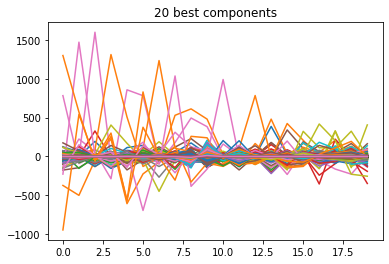

In [0]:
for i in range(data_reduced_20.shape[0]):
  plt.plot(range(20),data_reduced_20[i,:])
plt.title('20 best components')

**LocalOutlierFactor** will compute a metric for all observations in the test sample and find the neighbors in the train sample. It then gives a score for the furthest observations.

In [0]:
lof = LocalOutlierFactor(n_neighbors = 5, novelty = True, metric= 'euclidean')
lof.fit(data_reduced_20)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='euclidean', metric_params=None, n_jobs=None,
                   n_neighbors=5, novelty=True, p=2)

In [0]:
start_time = time.time()
data_test_reduced = pca_20.fit_transform(data_test)
print("{} seconds".format(round(time.time() - start_time,2)))

7.26 seconds


In [0]:
scores = -lof.score_samples(data_test_reduced) # we take the opposite since we want the higher the more abnormal

In [0]:
# np.savetxt('/content/gdrive/My Drive/scores_anomaly_pca20_lof.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.686067027575 (8/20) - 16/04

**Neighbors (no PCA)**

I wanted to see whether it's possible to perform LOF directly on the observations but it took too much time (as expected).

****PCA (100) + Neighbors****

PCA using 100 components in order to catch more variance.

In [0]:
start_time = time.time()
pca_100 = PCA(n_components = 100)
data_reduced_100 = pca_100.fit_transform(data)
print("{} seconds".format(round(time.time() - start_time,2)))

10.4 seconds


In [0]:
np.sum(pca_100.explained_variance_ratio_)

0.6721354238449947

67% is much higher than 37% we had previously --> let's try scoring

In [0]:
start_time = time.time()
data_test_reduced_100 = pca_100.fit_transform(data_test)
print("{} seconds".format(round(time.time() - start_time,2)))

14.65 seconds


In [0]:
start_time = time.time()
lof_100 = LocalOutlierFactor(n_neighbors = 5, novelty = True, metric= 'euclidean')
lof_100.fit(data_reduced_100)
print("{} seconds".format(round(time.time() - start_time,2)))

0.54 seconds


In [0]:
scores = -lof.score_samples(data_test_reduced_100)

In [0]:
# np.savetxt('/content/gdrive/My Drive/scores_anomaly_pca100_lof.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.517430506631 - 17/04

We conclude that allowing more components does not necessarily give best results.

**Stationarity**

I am now focusing on stationarity to give a score for each observation.

<a name="stationarity">ref:stationarity</a>

24.61 seconds


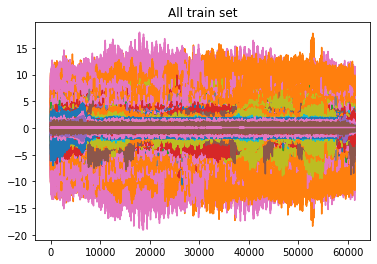

In [0]:
start_time = time.time()
for i in range(data.shape[0]):
  plt.plot(range(data.shape[1]),data[i,:])
plt.title('All train set')
print("{} seconds".format(round(time.time() - start_time,2)))

Displaying all train set makes it difficult to know whether there is stationarity.


0.15 seconds


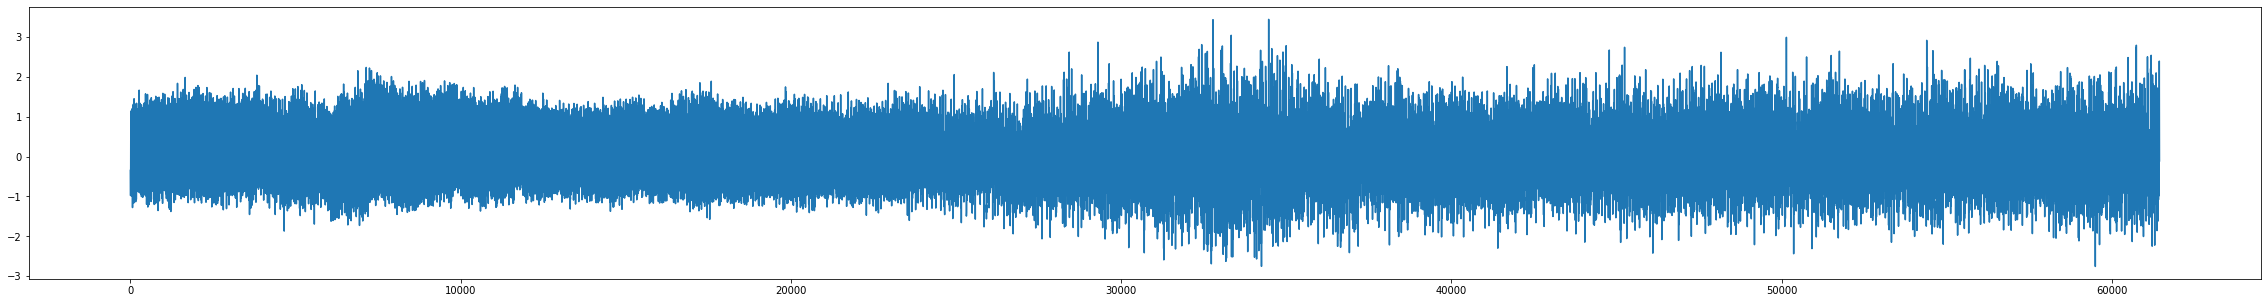

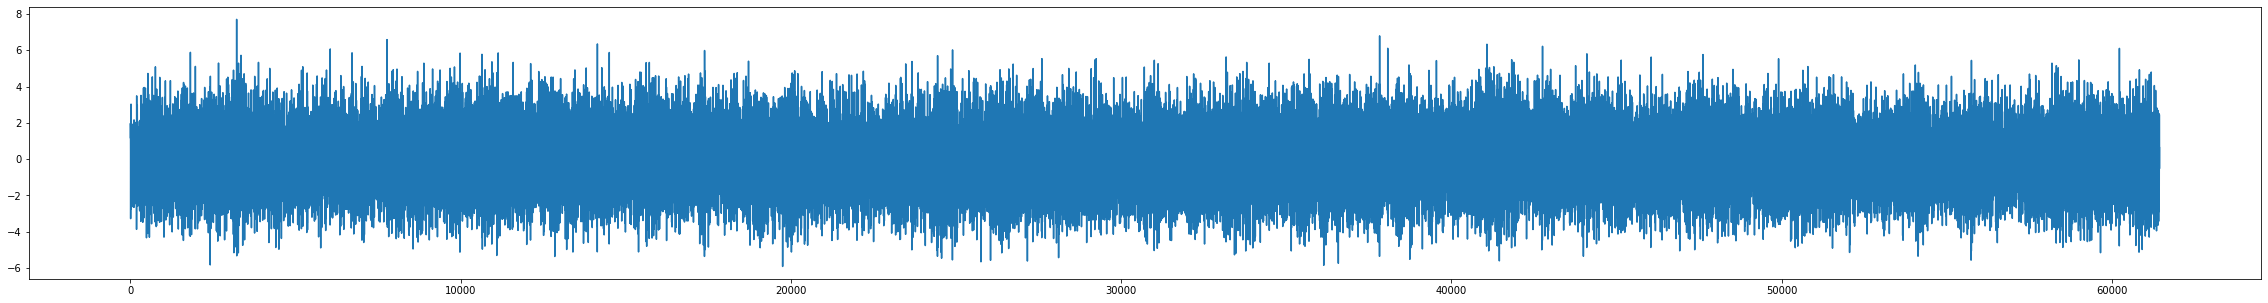

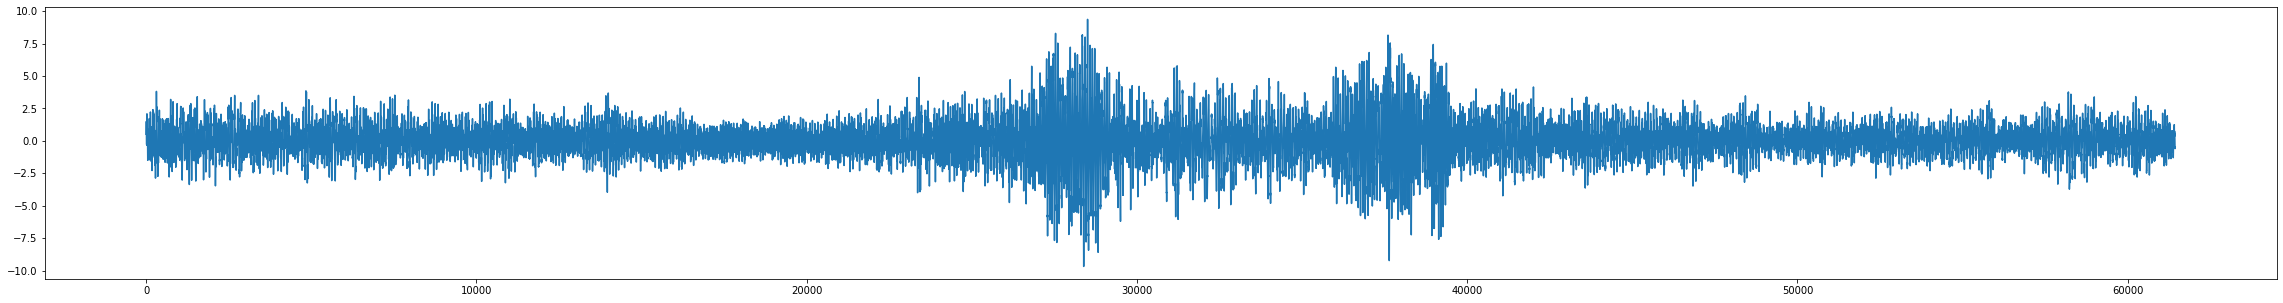

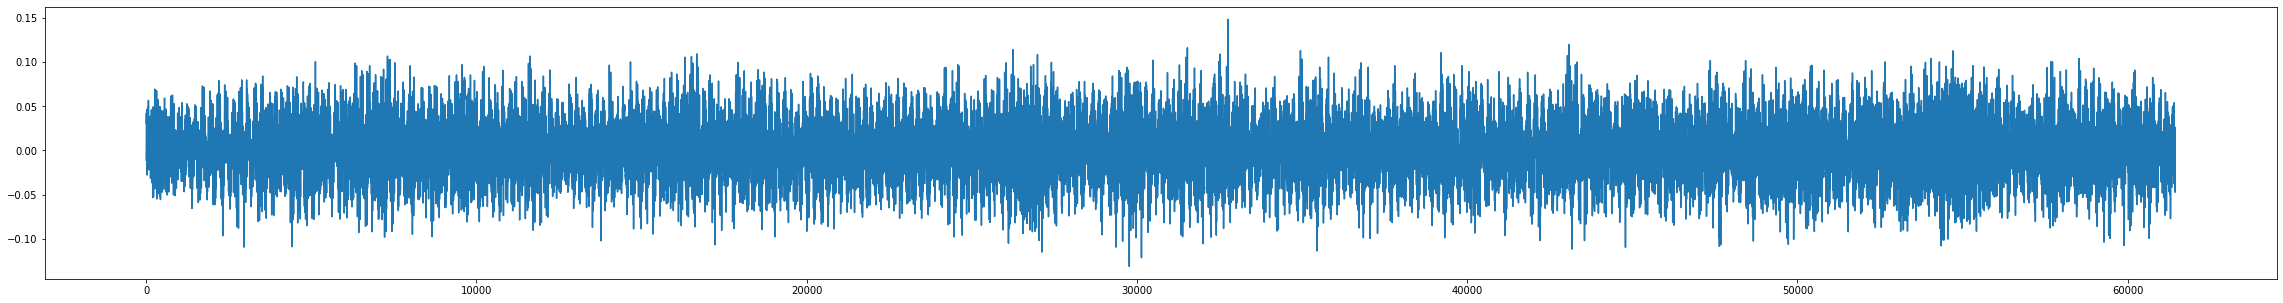

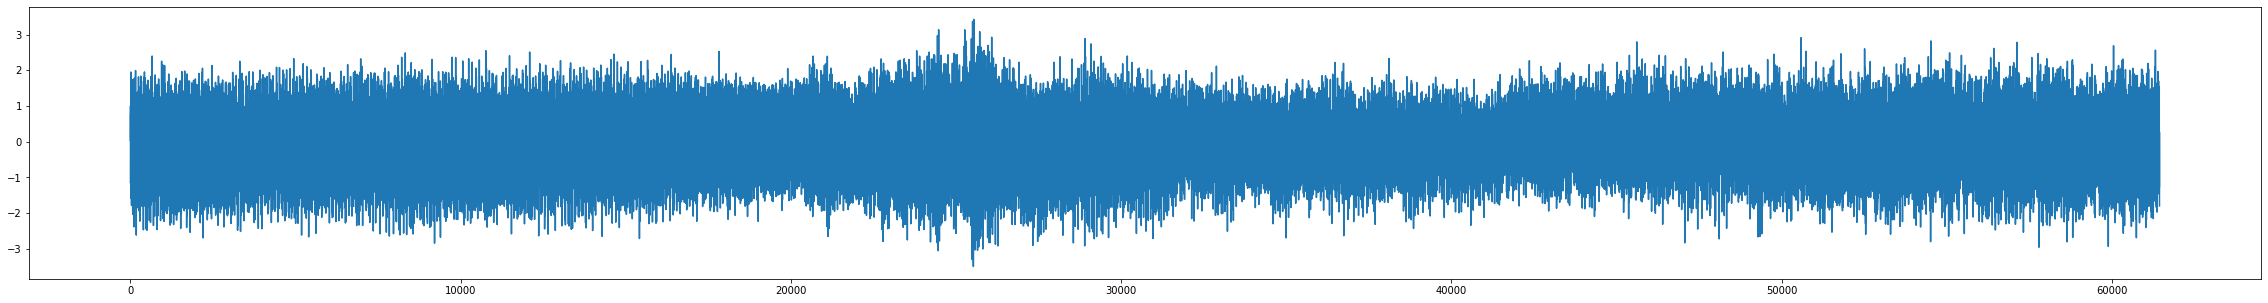

In [0]:
start_time = time.time()
random_state_list = [59,46,2,1,899]
for s in random_state_list:
  #random.seed(s)
  n = int(random.random()*data.shape[0])
  fig = plt.figure(figsize=(40,5))
  plt.plot(range(data.shape[1]),data[n,:])
print("{} seconds".format(round(time.time() - start_time,2)))

Comparing with test data below, we can confirm that train data seem to **not have outliers** because random observations appear stationary.

<a name="display_anomalies">ref:display_anomalies</a>

173
803
2071
2117
339
0.13 seconds


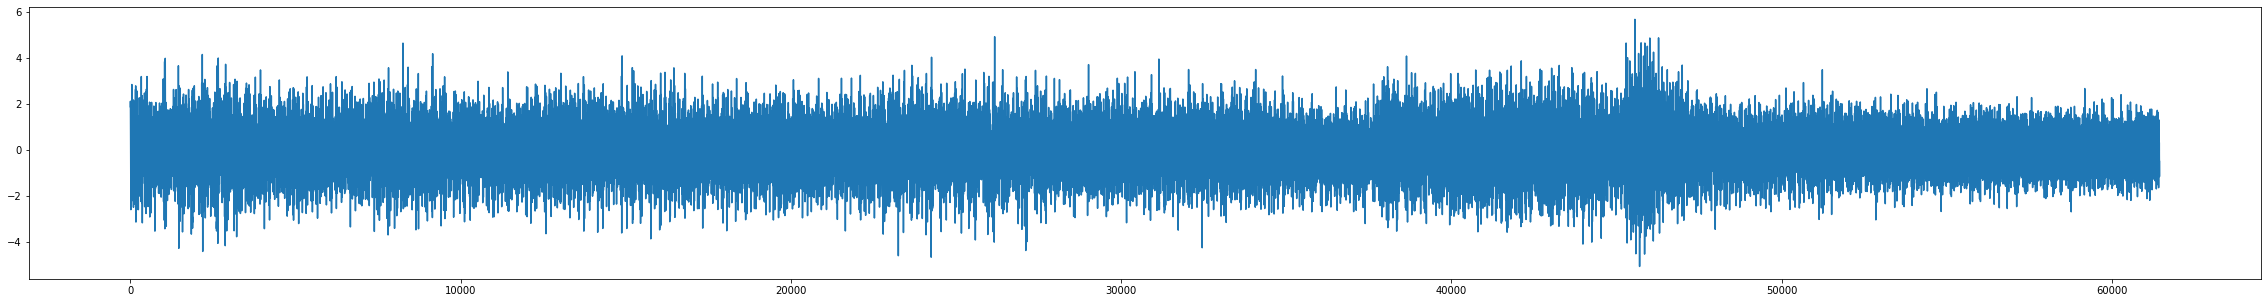

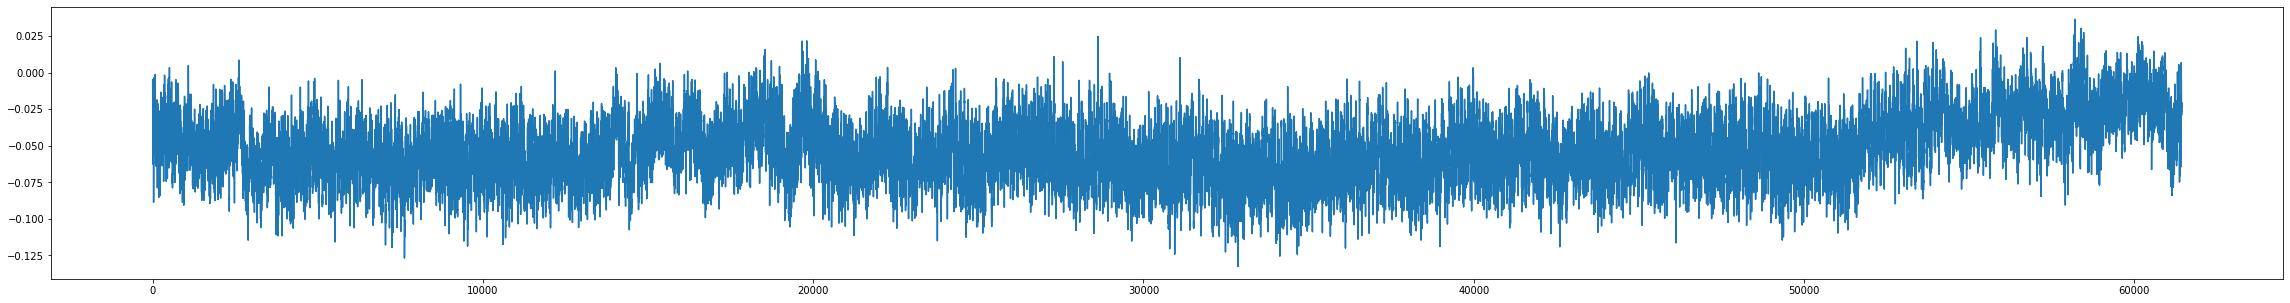

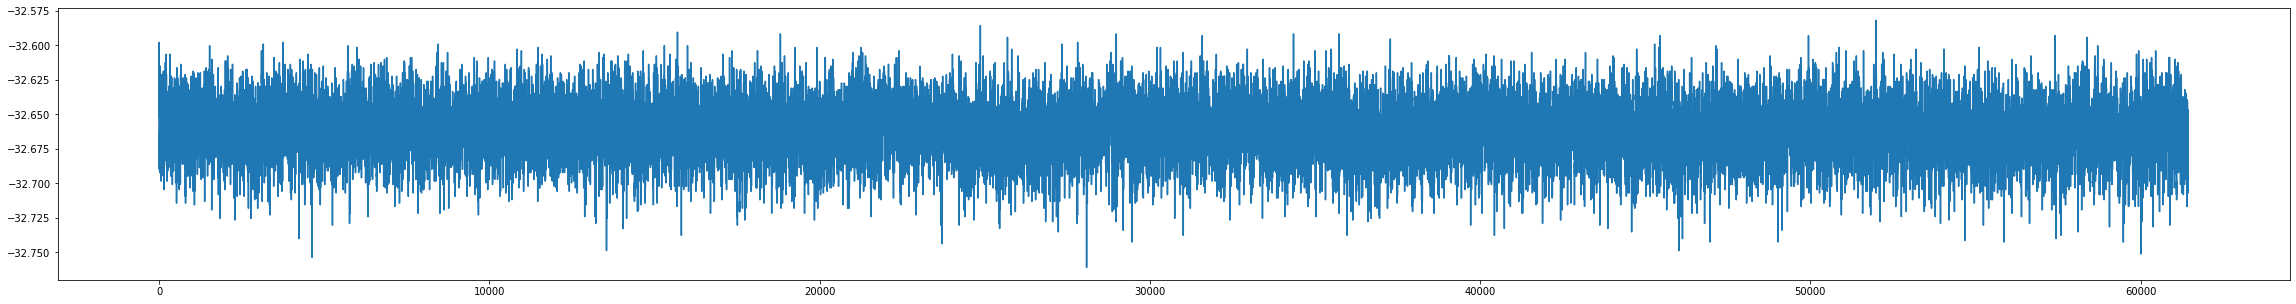

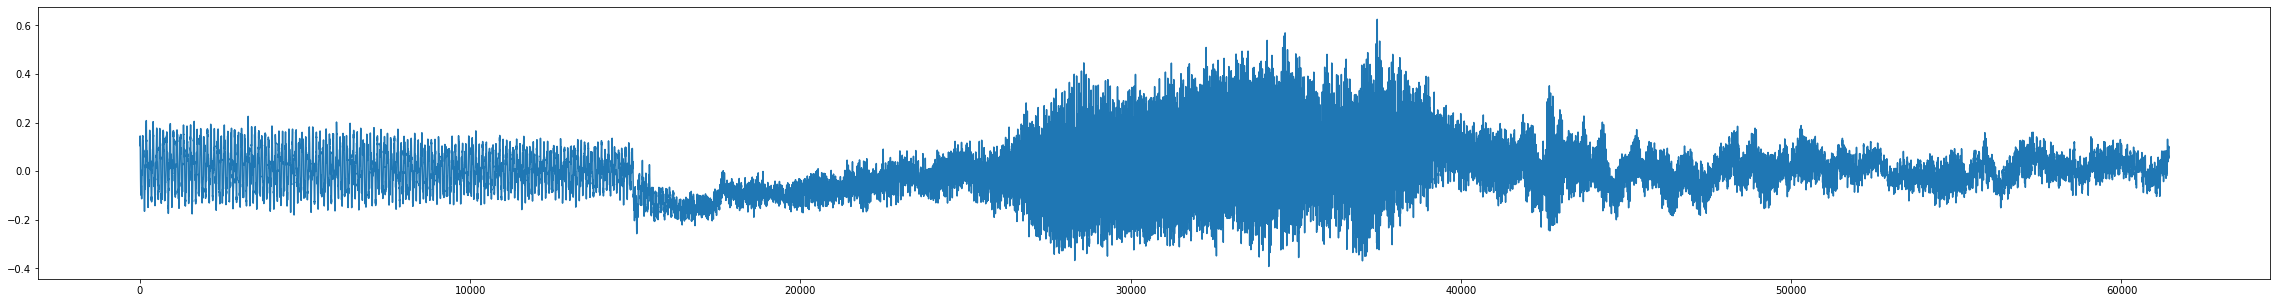

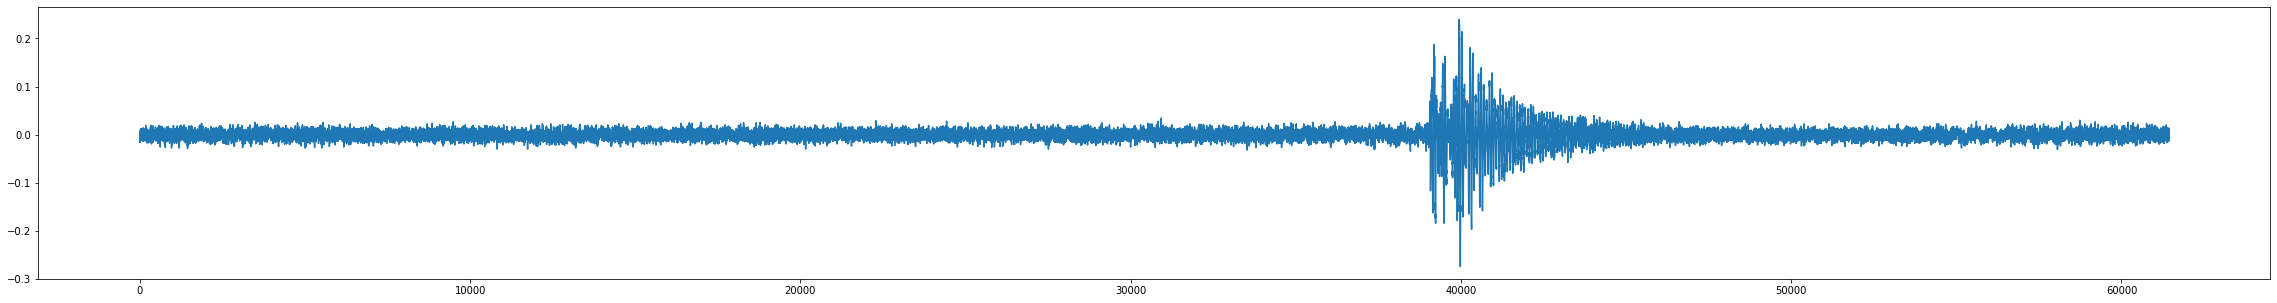

In [0]:
start_time = time.time()
random_state_list = [59,46,2,1,899]
for s in random_state_list:
  #random.seed(s)
  n = int(random.random()*data_test.shape[0])
  print(n)
  fig = plt.figure(figsize=(40,5))
  plt.plot(range(data.shape[1]),data_test[n,:])
print("{} seconds".format(round(time.time() - start_time,2)))

*ADF (Augmented Dickey-Fuller test is used to measure stationarity of a time serie*

In [0]:
start_time = time.time()
observation_index_list = [562,2230,2400,337,2035]
for i in observation_index_list:
  res_af = adfuller(data_test[i], autolag='AIC')
  print('ADF p-value: {}'.format(res_af[1]))
print("{} seconds".format(round(time.time() - start_time,2)))

ADF p-value: 0.0
ADF p-value: 0.0
ADF p-value: 1.4514797225057198e-23
ADF p-value: 0.0
ADF p-value: 2.6685818468587535e-10
45.33 seconds


We notice that p-values are higher for case 3 and 5 --> these observations are less stationary and thus seem to be outliers.

*PCA (20) + ADF*



As seen previously, ADF test seems to be a good measure for outliers.

Since performing the ADF test on all sample takes too long to run, I am trying to run it on reduced data.

In [0]:
start_time = time.time()
pca_20 = PCA(n_components = 20)
data_test_reduced_20 = pca_20.fit_transform(data_test)
print("{} seconds".format(round(time.time() - start_time,2)))

6.47 seconds


Let's see first if performing a PCA on reduced data makes sense.

In [0]:
start_time = time.time()
p_val_list_pca = []
for i in range(10):
  res_af = adfuller(data_test_reduced_20[i], autolag='AIC')
  print('ADF p-value: {}'.format(res_af[1]))
  p_val_list_pca.append(res_af[1])
print("{} seconds".format(round(time.time() - start_time,2)))

ADF p-value: 0.22475808061933644
ADF p-value: 0.6975692978344807
ADF p-value: 0.01633713251317538
ADF p-value: 0.3443028671133732
ADF p-value: 0.30188827339032465
ADF p-value: 1.0
ADF p-value: 0.6483317403026438
ADF p-value: 0.7717312209337198
ADF p-value: 0.0
ADF p-value: 0.8619368436697623
0.05 seconds


In [0]:
start_time = time.time()
p_val_list = []
for i in range(10):
  res_af = adfuller(data_test[i], autolag='AIC')
  print('ADF p-value: {}'.format(res_af[1]))
  p_val_list.append(res_af[1])
print("{} seconds".format(round(time.time() - start_time,2)))

ADF p-value: 2.9278748082824872e-06
ADF p-value: 4.6713875125022944e-24
ADF p-value: 0.0
ADF p-value: 4.6117721396453625e-14
ADF p-value: 0.0
ADF p-value: 3.7379782601026384e-30
ADF p-value: 3.839089148325222e-28
ADF p-value: 0.0
ADF p-value: 2.5680433882320904e-26
ADF p-value: 0.0
89.3 seconds


We can already see that trend stationarity is not consistent when doing the test on reduced data...

*ADF on averaged data (per cycle)*

Since ADF test is not consistent on reduced data with PCA, let's see what it gives on reduced data with average smoothing.

In [0]:
start_time = time.time()
a = np.zeros((data_test.shape[0], int(data_test.shape[1]/1024)))
s = 0
for i in range(data_test.shape[0]):
  k=0
  for j in range(data_test.shape[1]):
    s += data_test[i,j]
    if(j % 1024 != 0):
      continue
    else:
      a[i,k] = s / 60
      k += 1
      s = 0
print("{} seconds".format(round(time.time() - start_time,2)))

72.81 seconds


In [0]:
start_time = time.time()
observation_index_list = [562,2230,2400,337,2035]
for i in observation_index_list:
  res_af = adfuller(a[i], autolag='AIC')
  print('ADF p-value: {}'.format(res_af[1]))
print("{} seconds".format(round(time.time() - start_time,2)))

ADF p-value: 0.000792474172017744
ADF p-value: 0.0
ADF p-value: 0.1098875622721125
ADF p-value: 0.17053944268777654
ADF p-value: 0.30716237698172577
0.08 seconds


Comparing with previous results, it seems to work well for 4 out of 5 tested observations.

In [0]:
start_time = time.time()
res = []
for i in range(data_test.shape[0]):
  res_af = adfuller(a[i], autolag='AIC')
  res.append(res_af[1])
print("{} seconds".format(round(time.time() - start_time,2)))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


15.91 seconds


In [0]:
np.savetxt('/content/gdrive/My Drive/scores_adf.csv', np.array(res), fmt = '%1.6f', delimiter=',')

Score 0.474822944863 - 29/04

The result is awfully bad so we forget this method.

*ADF on last minute*

One assumption we could make is that if one sensor is broken, the behavior will be the worst at the last cycle (as it gets worst with time). Thus, I chose to focus on the last cycle.

In [0]:
data_test[:,61440-1024:].shape

(2511, 1024)

In [0]:
start_time = time.time()
res = []
for i in range(data_test.shape[0]):
  res_af = adfuller(data_test[:,61440-1024:][i], autolag='AIC')
  res.append(res_af[1])
print("{} seconds".format(round(time.time() - start_time,2)))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


110.72 seconds


In [0]:
np.savetxt('/content/gdrive/My Drive/scores_adf_last.csv', np.array(res), fmt = '%1.6f', delimiter=',')

Score 0.58 - 29/04

The score is slightly better but still lower than PCA + LOF method.

**Autoencoder**

<a name="autoencoders">ref:autoencoders</a>

Autoencoders can be used to replace older dimensionality reduction methods such as PCA for several reasons:

- For very large data sets that can't be stored in memory, PCA will not be able to be performed.
The autoencoder construction using keras can easily be batched resolving memory limitations.

- PCA is restricted to linear separation while autoencoders are capable of modelling complex non
linear functions.

In [0]:
!pip install tensorflow

In [0]:
import tensorflow as tf
print(tf.__version__)

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

from numpy.random import seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
from keras.initializers import Ones, RandomNormal
from keras import optimizers

In [0]:
seed(10)
tf.random.set_seed(10)
act_func = 'relu'

model=Sequential()

model.add(Dense(25,activation=act_func,
                kernel_initializer=RandomNormal(),
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(data.shape[1],)
               )
         )
model.add(Dense(3,activation=act_func,
                kernel_initializer=RandomNormal()))
model.add(Dense(25,activation=act_func,
                kernel_initializer=RandomNormal()))
model.add(Dense(data.shape[1],
                kernel_initializer=RandomNormal()))
model.compile(loss='mse',optimizer='adam')

In [0]:
NUM_EPOCHS=5
BATCH_SIZE=10

In [0]:
history=model.fit(np.array(data_std),np.array(data_std),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 1593 samples, validate on 84 samples
Epoch 1/5
1593/1593 [==============================] - 3s 2ms/step - loss: 1.0305 - val_loss: 0.4265
Epoch 2/5
1593/1593 [==============================] - 3s 2ms/step - loss: 1.0212 - val_loss: 0.4232
Epoch 3/5
1593/1593 [==============================] - 2s 2ms/step - loss: 1.0174 - val_loss: 0.4215
Epoch 4/5
1593/1593 [==============================] - 2s 2ms/step - loss: 1.0242 - val_loss: 0.4219
Epoch 5/5
1593/1593 [==============================] - 3s 2ms/step - loss: 1.0115 - val_loss: 0.4209


After several tests with different nodes/epochs, I could get a decreasing loss function.

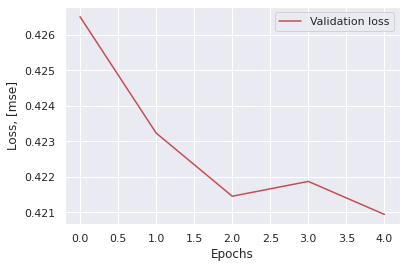

In [0]:
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.show()

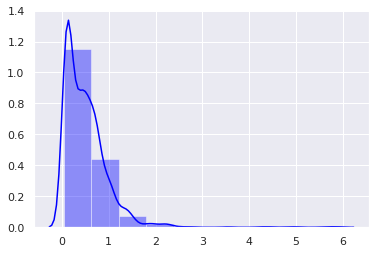

In [0]:
X_pred_train = model.predict(np.array(data))

scores_train = np.mean(np.abs(X_pred_train-data), axis = 1)

plt.figure()
sns.distplot(scores_train,
             bins = 10, 
             kde= True,
            color = 'blue');

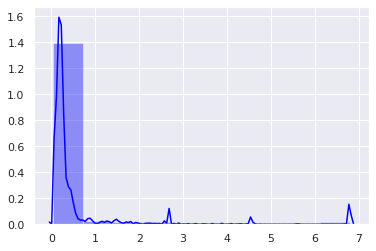

In [0]:
X_pred_test = model.predict(data_test_std)

scores_test = np.mean(np.abs(X_pred_test-data_test_std), axis = 1)

plt.figure()
sns.distplot(scores_test,
             bins = 10, 
             kde= True,
            color = 'blue');

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_ae_std.csv', scores_test, fmt = '%1.6f', delimiter=',')

Score 0.442171258358 (30 epoch, 10-3-10 nodes) - 28/04

Score 0.465730715513 (100 epoch, 10-3-10 nodes) - 28/04

Score 0.624470070575 (1000 epoch, 10-3-10 nodes, Ones initializer) - 28/04

Score 0.621721544489 (100 epoch, 25-3-25 nodes) - 28/04

Score 0.615665208202 (20 epoch, 25-3-3-25) - 28/04

Despite several test using different epochs/layers/nodes/batch, I couldn't manage to get a good score.

**LSTM**

I wanted to try LSTM as it appeared to be a good alternative to the autoencoder.

<a name="lstm">ref:lstm</a>

In [0]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
from keras.initializers import Ones, RandomNormal
from keras import optimizers

In [0]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [0]:
data_reshaped = data.reshape(data.shape[0],1,data.shape[1])
model = autoencoder_model(data_reshaped)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 61440)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 1, 16)             3933248   
_________________________________________________________________
lstm_18 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 61440)          1044

In [0]:
nb_epochs = 20
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 1593 samples, validate on 84 samples
Epoch 1/20
1593/1593 [==============================] - 5s 3ms/step - loss: 0.8706 - val_loss: 0.3579
Epoch 2/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8702 - val_loss: 0.3579
Epoch 3/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8634 - val_loss: 0.3535
Epoch 4/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8593 - val_loss: 0.3532
Epoch 5/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8574 - val_loss: 0.3537
Epoch 6/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8574 - val_loss: 0.3540
Epoch 7/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8568 - val_loss: 0.3539
Epoch 8/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8567 - val_loss: 0.3541
Epoch 9/20
1593/1593 [==============================] - 4s 3ms/step - loss: 0.8549 - val_loss: 0.3544
Epoch 10/20
1593/1593 [=============

KeyboardInterrupt: ignored

Obtained scores were similar than the autoencoder.

**Score averaging**

Another method I wanted to try is to combine scores from several methods.

<a name="score_averaging">ref:score_averaging</a>

In [0]:
PCA_scores = 'https://drive.google.com/open?id=1suy7cR82T9krquHy6_nwhiM1sbpdkQ8H'
fluff, id_pca = PCA_scores.split('=')
AE_scores = 'https://drive.google.com/open?id=1-27DtL9a-XXWunF5T1JqBopDEsOrQZrE'
fluff, id_ae = AE_scores.split('=')

downloaded = drive.CreateFile({'id':id_pca}) 
downloaded.GetContentFile('scores_anomaly_pca20_lof.csv') 

downloaded = drive.CreateFile({'id':id_ae}) 
downloaded.GetContentFile('scores_anomaly_ae_epoch_1000.csv') 

scores_pca = np.loadtxt('scores_anomaly_pca20_lof.csv', delimiter= ' ')
scores_ae = np.loadtxt('scores_anomaly_ae_epoch_1000.csv', delimiter= ' ')

In [0]:
ave_scores = []
for i in range(len(scores_pca)):
  ave_scores.append((scores_pca[i] + scores_ae[i]) /2)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_ave_pca_ae_2.csv', ave_scores, fmt = '%1.6f', delimiter=',')

Score 0.624470070575 (Error - same file as AE) - 28/04

Score 0.628551917634 (average PCA/LOF + AE)

This method didn't bring significant value.

**PCA + Isolation Forests**

Isolation Forests appeared to be a very famous method for anomaly detection.

<a name="pca_isolation_forests">ref:pca_isolation_forests</a>

In [0]:
!pip install eif

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for eif: filename=eif-2.0.2-cp36-cp36m-linux_x86_64.whl size=250774 sha256=f32b980ff23fc9ed4dc6003d70e1ba1e4e53693ff8ece0af2e68071e36bbfaa4
  Stored in directory: /root/.cache/pip/wheels/24/ff/c3/6a610ba4a6c8e968483ba15a0e38feacd7c0a26c932b2f91bd
Successfully built eif


In [0]:
from sklearn.ensemble import IsolationForest
import eif as iso

In [0]:
pca_5 = PCA(n_components = 5)
data_reduced_5 = pca_5.fit_transform(data)

clf_if = IsolationForest(n_estimators=30, max_samples=100, random_state=0)
clf_if.fit(data_reduced_5)

data_test_reduced = pca_5.fit_transform(data_test)

scores_if = clf_if.decision_function(data_test_reduced)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_if_pca_5.csv', -scores_if, fmt = '%1.6f', delimiter=',')

Score 0.704273116047 (PCA IF 20) - 29/04

Score 0.631573905843 (PCA IF 20 split) - 29/04

Score 0.700677938868 (PCA IF 20 est 100) - 29/04

Score 0.709845872421 (PCA IF 20 est 40) - 29/04 (41/47)

Score 0.713822660586 (PCA IF 20 est 30) - 29/04 (38/47)

Score 0.7080227916 (PCA IF 20 est 20) - 29/04

This method allowed me to reach 70%.

**Autoencoder + Isolation Forests**

<a name="autoencoder_isolation_forests">ref:autoencoder_isolation_forests</a>

In [0]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [0]:
encoding_dim = 20

input_df = Input(shape=(data.shape[1],))
encoded = Dense(encoding_dim, activation='relu')(input_df)
decoded = Dense(data.shape[1], activation='sigmoid')(encoded)

# encoder
autoencoder = Model(input_df, decoded)

# intermediate result
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [0]:
NUM_EPOCHS=500
BATCH_SIZE=10

In [0]:
autoencoder.fit(np.array(data),np.array(data),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 1593 samples, validate on 84 samples
Epoch 1/500
1593/1593 [==============================] - 2s 1ms/step - loss: 1.1103 - val_loss: 0.5984
Epoch 2/500
1593/1593 [==============================] - 2s 1ms/step - loss: 1.1075 - val_loss: 0.5954
Epoch 3/500
1593/1593 [==============================] - 2s 1ms/step - loss: 1.0854 - val_loss: 0.5780
Epoch 4/500
1593/1593 [==============================] - 2s 1ms/step - loss: 1.0297 - val_loss: 0.5540
Epoch 5/500
1593/1593 [==============================] - 2s 1ms/step - loss: 0.9828 - val_loss: 0.5360
Epoch 6/500
1593/1593 [==============================] - 2s 1ms/step - loss: 0.9565 - val_loss: 0.5232
Epoch 7/500
1593/1593 [==============================] - 2s 1ms/step - loss: 0.9416 - val_loss: 0.5143
Epoch 8/500
1593/1593 [==============================] - 2s 1ms/step - loss: 0.9319 - val_loss: 0.5078
Epoch 9/500
1593/1593 [==============================] - 2s 1ms/step - loss: 0.9247 - val_loss: 0.5029
Epoch 10/500
1593/1593 [===

In [0]:
encoded_data = encoder.predict(data)

In [0]:
from sklearn.ensemble import IsolationForest

clf_if = IsolationForest(n_estimators=30, max_samples=100, random_state=0)
clf_if.fit(encoded_data)

encoded_data_test = encoder.predict(data_test)

scores_if = clf_if.decision_function(encoded_data_test)

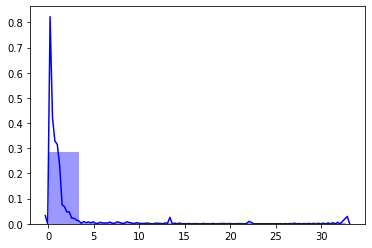

In [0]:
X_pred_test = autoencoder.predict(data_test)

scores_test = np.mean(np.abs(X_pred_test-data_test), axis = 1)

plt.figure()
sns.distplot(scores_test,
             bins = 10, 
             kde= True,
            color = 'blue');

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_autoencoder_500epochs.csv', scores_test, fmt = '%1.6f', delimiter=',')

Score 0.581406738601 (encoder 20epochs IF) - 29/04

Score 0.652979655654 (encoder 100epochs IF) - 29/04

Score 0.62583274624 (encoder 500epochs IF) - 29/04

Score 0.619621911577 (autoencoder 500epochs) - 29/04

Autoencoder combined with Isolation Forests didn't give better results than using PCA.

This result surprised me since autoencoder is supposed to find most complex transformations than PCA.

I then wanted to replace Isolation Forests by LocalOutlierFactor.

<a name="autoencoder_lof">ref:autoencoder_lof</a>

In [0]:
start_time = time.time()
lof = LocalOutlierFactor(n_neighbors = 5, novelty = True, metric= 'euclidean')
lof.fit(encoded_data)
print("{} seconds".format(round(time.time() - start_time,2)))

0.08 seconds


In [0]:
scores = -lof.score_samples(encoded_data_test)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_lof_encoder.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.559996353838 (encoder 20epochs lof) - 29/04

**IF with feature engineering**

Since the best score so far is using Isolation Forests, I wanted to replace PCA with relevant features.

<a name="feature_engineering_if">ref:feature_engineering_if</a>

In [0]:
from sklearn.ensemble import IsolationForest

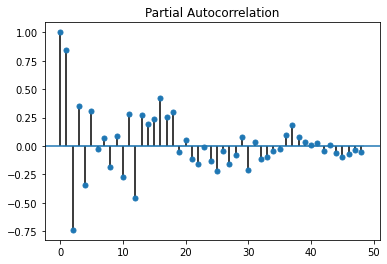

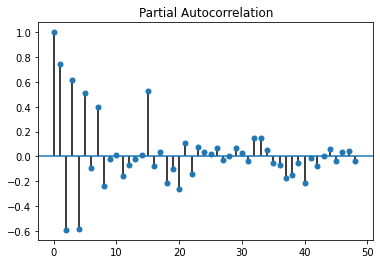

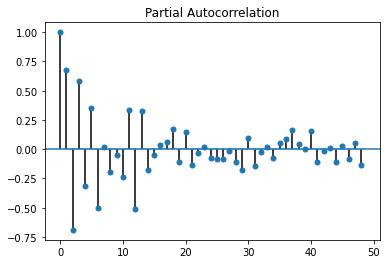

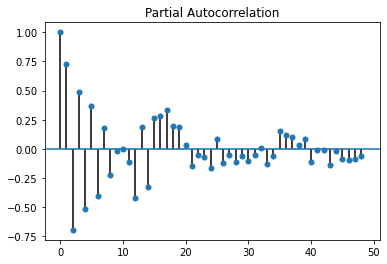

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for i in [15, 95, 88, 250]:
  plot_pacf(data[i], alpha=0.1)

We can see that autocorrelation lags should be around 5.

In [0]:
def standardize(s):
  return (s - np.mean(s))/np.std(s) # same as StandardScaler().fit_transform(data)

def preproc(d):
  df = pd.DataFrame(d)
  x_autocorr = df.apply(lambda x: x.autocorr(lag=5), axis=1)
  x_var = df.apply(lambda x: np.var(x), axis=1)
  x_mean = df.apply(lambda x: np.mean(x), axis=1)
  x_min = df.apply(lambda x: np.min(x), axis=1)
  x_max = df.apply(lambda x: np.max(x), axis=1)

  return pd.concat([x_autocorr, x_var, x_mean, x_max, x_min], axis=1)

In [0]:
data_prep = preproc(data)
data_test_prep = preproc(data_test).fillna(500)

In [0]:
clf_if = IsolationForest(n_estimators=100, random_state=0)
clf_if.fit(data_prep)

scores_if = clf_if.decision_function(data_test_prep)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_feat_if_weights_autocorr.csv', -scores_if, fmt = '%1.6f', delimiter=',')

Score 0.757755818409 (feat IF) - 30/04

Score 0.754661215964 (feat IF est200) - 30/04

Score 0.755520226927 (feat IF est50) - 30/04

Score 0.75604088645 (feat IF est110) - 30/04

Score 0.724688531277 (feat IF autocorr6) - 30/04

Score 0.741878020443 (feat IF autocorr4) - 30/04

Score 0.757675479254 (feat IF weight max) - 30/04

Score 0.757675479254 (feat IF weight autocorr) - 30/04

It looks like feature engineering is a good method.

**Preproc + LOF**

<a name="feature_engineering_lof">ref:feature_engineering_lof</a>

In [0]:
def preproc(d):
  df = pd.DataFrame(d)
  x_autocorr = df.apply(lambda x: x.autocorr(lag=5), axis=1)
  x_var = df.apply(lambda x: np.var(x), axis=1)
  x_mean = df.apply(lambda x: np.mean(x), axis=1)
  x_min = df.apply(lambda x: np.min(x), axis=1)
  x_max = df.apply(lambda x: np.max(x), axis=1)

  return pd.concat([x_autocorr, x_var, x_mean, x_max], axis=1)

In [0]:
data_prep = preproc(data)
data_test_prep = preproc(data_test).fillna(500)

In [0]:
lof = LocalOutlierFactor(n_neighbors = 7, novelty = True, metric= 'euclidean')
lof.fit(data_prep)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='euclidean', metric_params=None, n_jobs=None,
                   n_neighbors=7, novelty=True, p=2)

In [0]:
scores = -lof.score_samples(data_test_prep)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_feat_lof_ma.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.777420371538 (feat LOF) - 30/04 (24/48)

Score 0.790446129507 (feat LOF 7neigh) - 30/04 (22/48)

Score 0.770444769921 (feat station LOF) - 30/04

Score 0.776709679014 (feat5 LOF) - 30/04

Score 0.753259915706 (feat3 LOF) - 30/04

LocalOutlierFactor allows to get better results than Isolation Forests.

**Mean difference**

I came back to stationarity since I really thought appropriate analysis could lead to better results.

One way I thought about is to do a simple mean difference splitting a time serie at the middle.

In [0]:
def preproc_mean(d):
  df = pd.DataFrame(d)
  x_stationarity_mean = df.apply(lambda x: np.mean(x[:int(len(x)/2)])-np.mean(x[int(len(x)/2):]), axis=1)
  return x_stationarity_mean

In [0]:
mean_diff = preproc_mean(data)
mean_diff_test = preproc_mean(data_test)

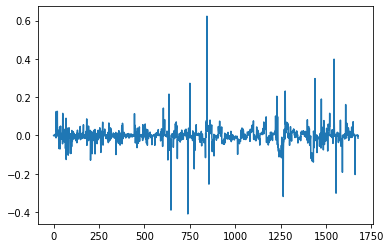

In [0]:
plt.plot(mean_diff)

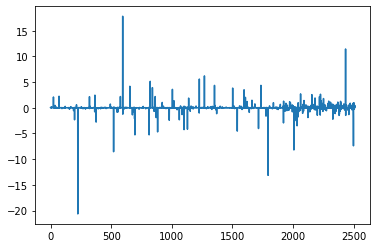

In [0]:
plt.plot(mean_diff_test)

We notice that the mean difference is significantly higher in the test dataset. This is expected as the test dataset has outliers, consequently means are more likely to change throughout the serie.

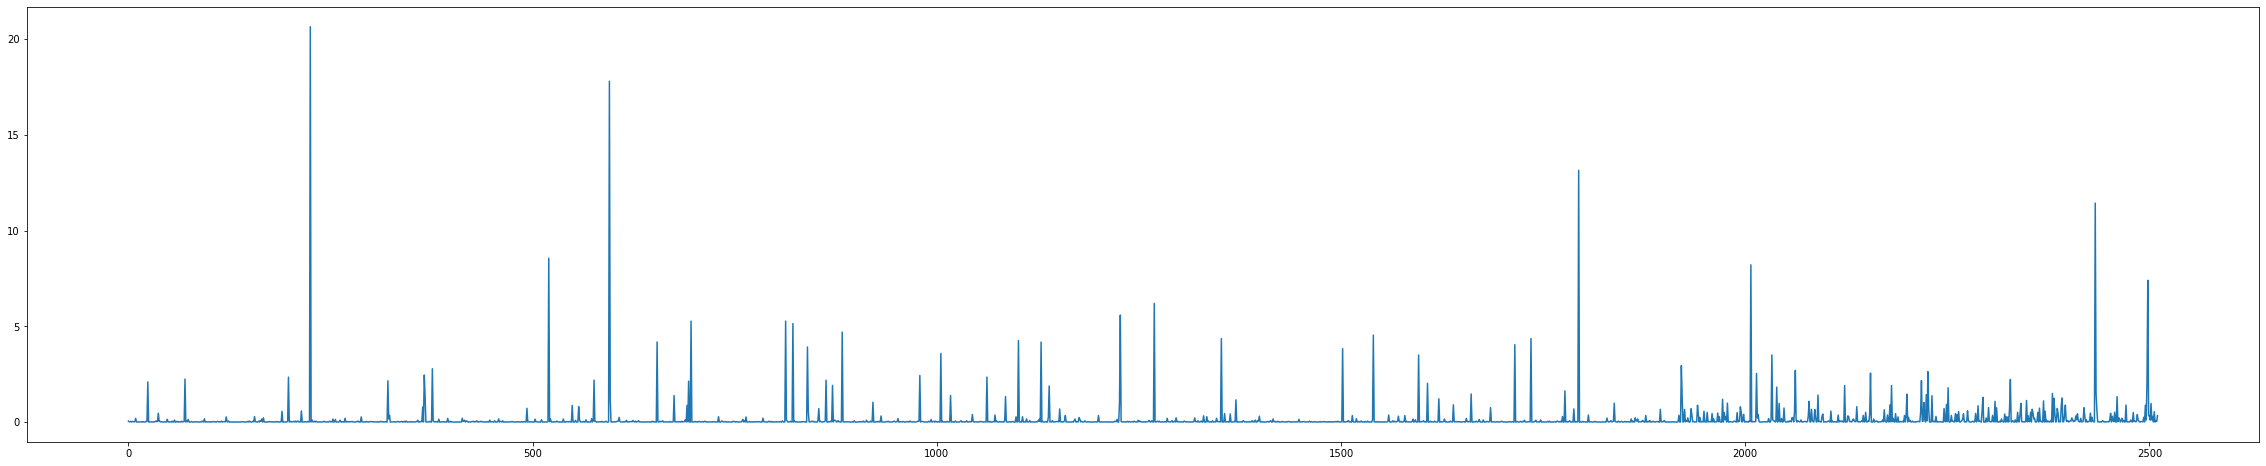

In [0]:
plt.figure(figsize=(40,8))
plt.plot(np.abs(mean_diff_test))

Let's focus on the max and min.

In [0]:
np.argmax(np.abs(mean_diff_test))  

225

In [0]:
np.argmin(np.abs(mean_diff_test))

1938

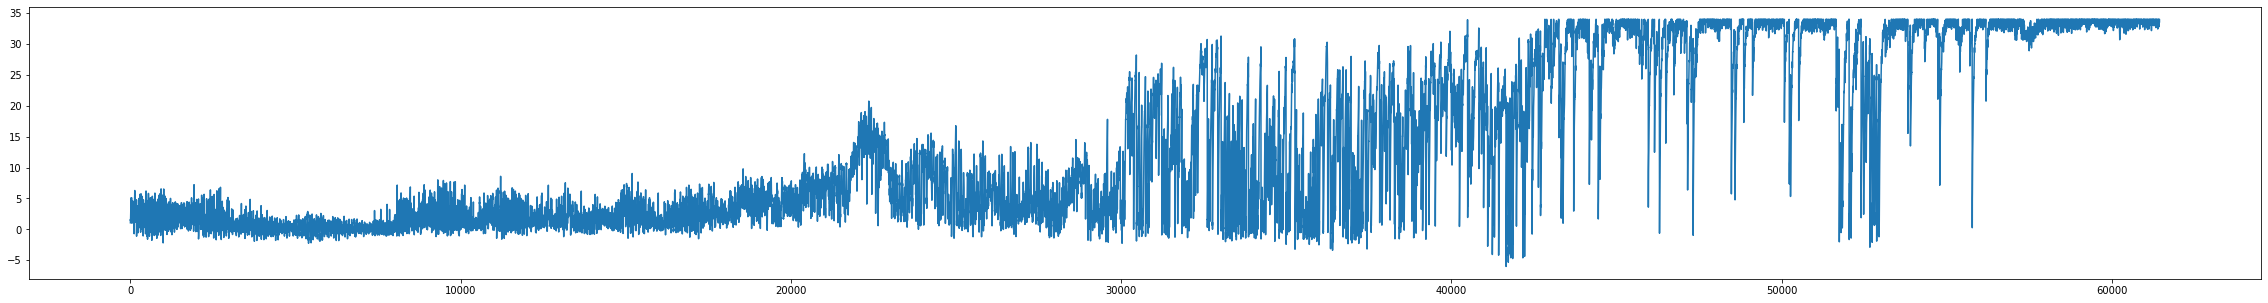

In [0]:
displayObservation(225, data_test)

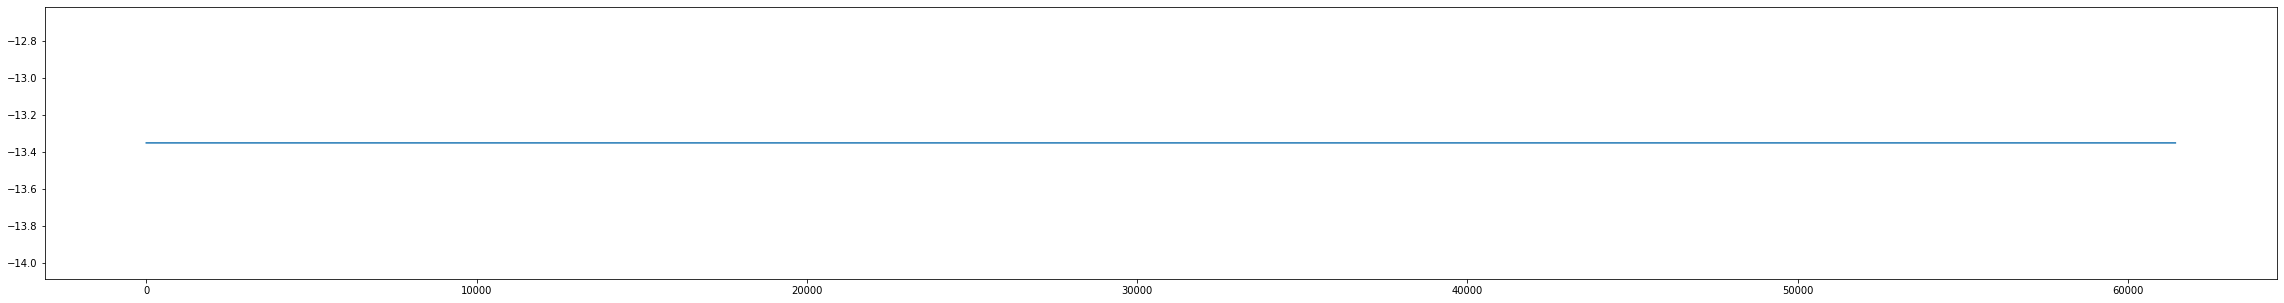

In [0]:
displayObservation(1938, data_test)

In [0]:
np.argmin(np.abs(mean_diff))

529

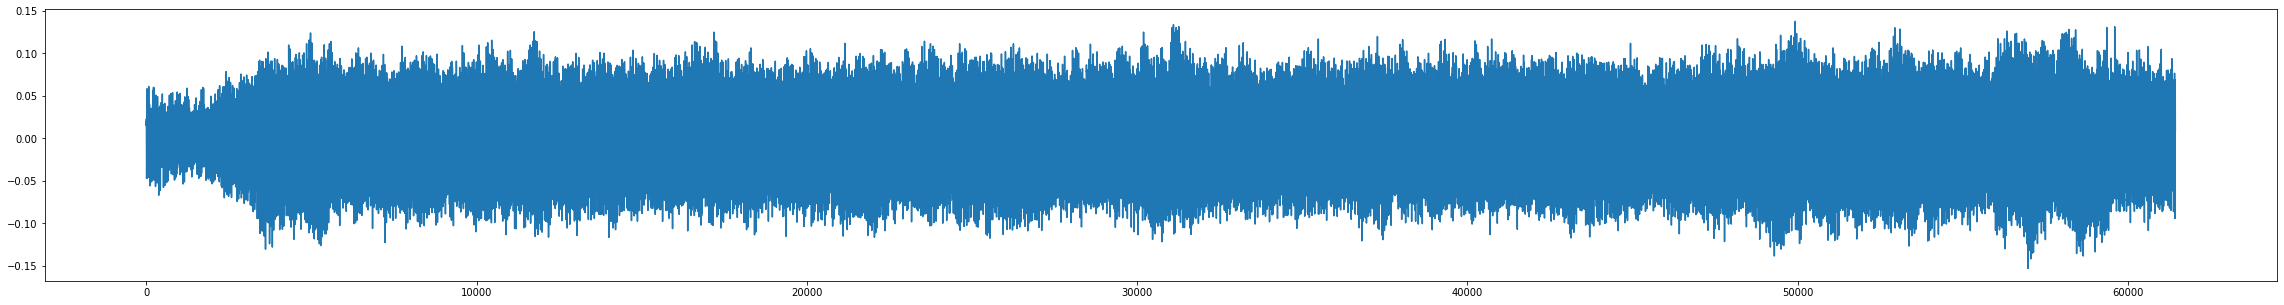

In [0]:
displayObservation(529, data)

We note that the max result is highly different from train and test set.

In [0]:
b[b == 0] = 500

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_mean_diff.csv', b, fmt = '%1.6f', delimiter=',')

Score 0.564997466227 (diff mean) - 30/04

Basing the classification only on this criteria is not a good choice.

**Data generation**

*Use moving average*

In [0]:
data_df = pd.DataFrame(data)

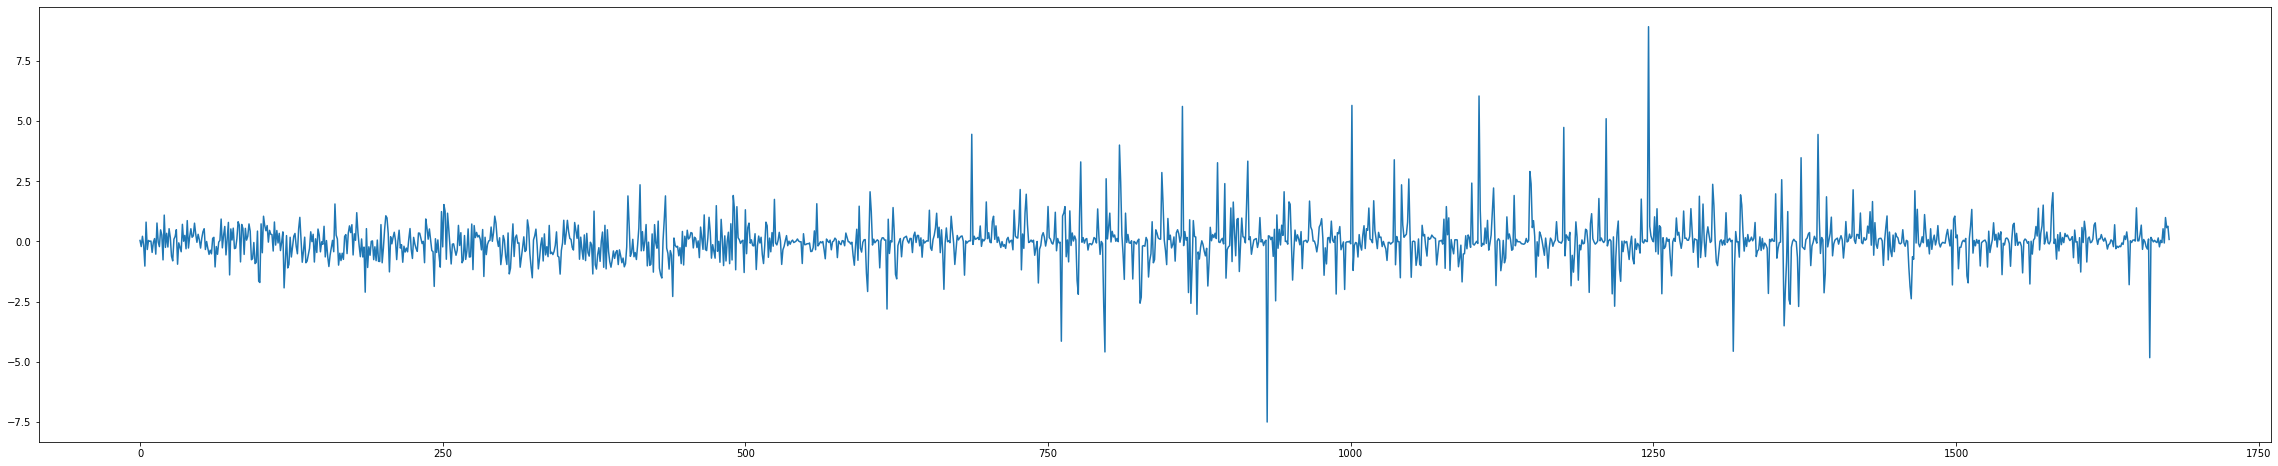

In [0]:
plt.figure(figsize=(40,8))
plt.plot(data_df[0])

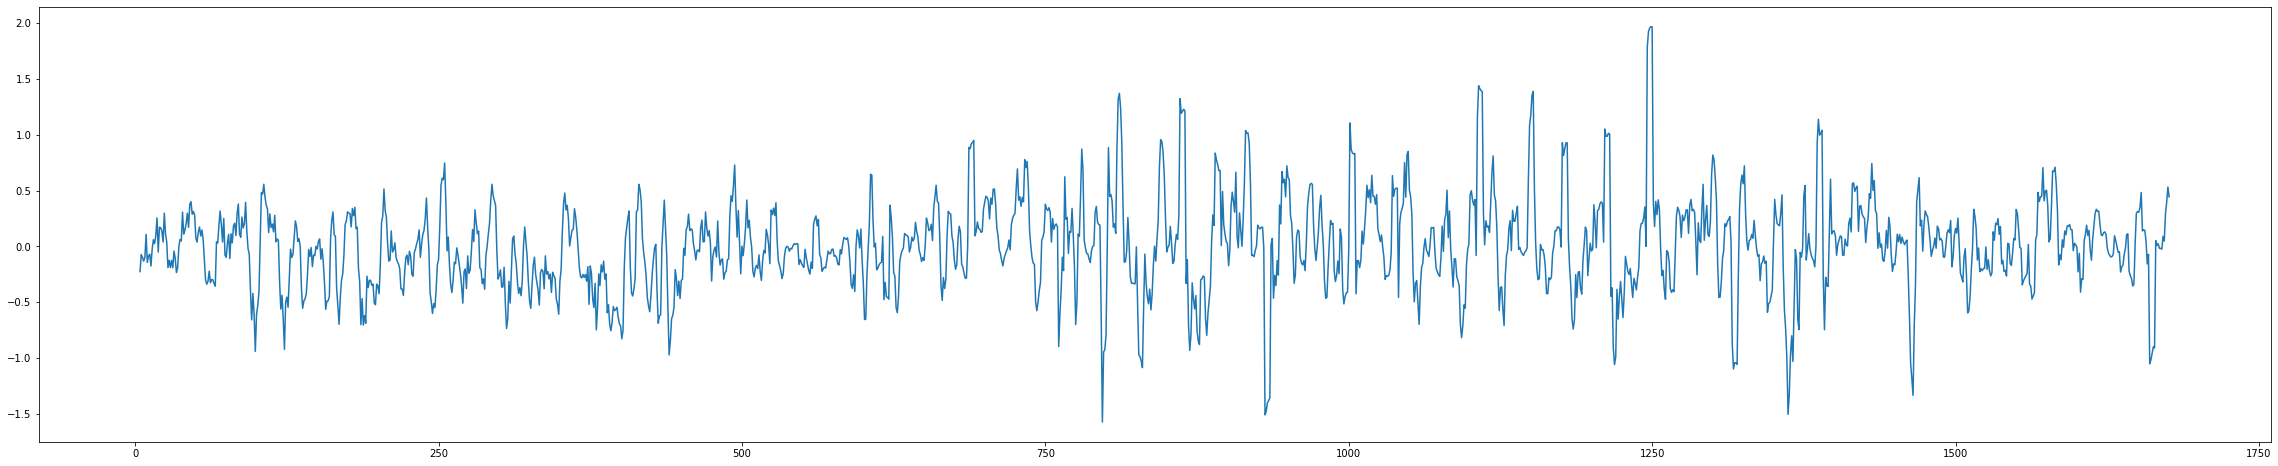

In [0]:
plt.figure(figsize=(40,8))
plt.plot(data_df[0].rolling(5).mean())

In [0]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [0]:
a = np.zeros((data.shape[0],data.shape[1]-4))
for i in range(data.shape[0]):
  a[i]=moving_average(data[i],5)

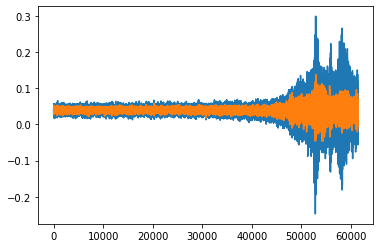

In [0]:
plt.plot(data[0])
plt.plot(a[0])

In [0]:
def preproc(d):
  df = pd.DataFrame(d)
  x_autocorr = df.apply(lambda x: x.autocorr(lag=5), axis=1)
  x_var = df.apply(lambda x: np.var(x), axis=1)
  x_mean = df.apply(lambda x: np.mean(x), axis=1)
  x_max = df.apply(lambda x: np.max(x), axis=1)
  x_sum = df.apply(lambda x: np.sum(x), axis=1)
  x_stationarity_mean = df.apply(lambda x: np.mean(x[:int(len(x)/2)])-np.mean(x[int(len(x)/2):]), axis=1)
  x_stationarity_var = df.apply(lambda x: np.var(x[:int(len(x)/2)])-np.var(x[int(len(x)/2):]), axis=1)

  return pd.concat([x_autocorr, x_var, x_mean, x_max, x_sum, x_stationarity_mean, x_stationarity_var], axis=1)

In [0]:
data_ma = np.zeros((data.shape[0],data.shape[1]-4))
for i in range(data.shape[0]):
  data_ma[i] = moving_average(data[i],5)
data_extend = np.concatenate((data[:,4:],data_ma), axis=0)

In [0]:
data_prep = preproc(data_extend)
data_test_prep = preproc(data_test).fillna(500)

[0.04275762]
[0.91593717]


In [0]:
lof = LocalOutlierFactor(n_neighbors = 9, novelty = True, metric= 'euclidean')
lof.fit(data_prep)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='euclidean', metric_params=None, n_jobs=None,
                   n_neighbors=9, novelty=True, p=2)

In [0]:
scores = -lof.score_samples(data_test_prep)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_featpca_ext+.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.757301593187 (feat LOF extend) - 30/04

Score 0.718361822834 (featPCA LOF ext+) - 01/05

Extending the data using moving average didn't improve results significantly.

<a name="data_generation_noise">ref:data_generation_noise</a>

*Adding noise*

In [0]:
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [data.shape[0],data.shape[1]])

In [0]:
data_noise = data + noise

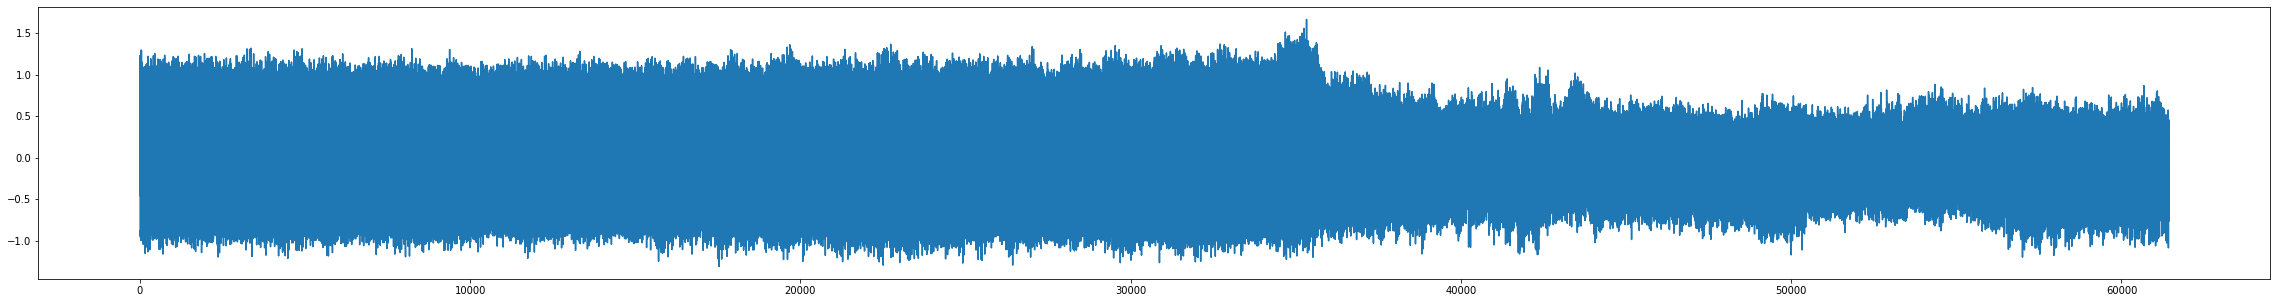

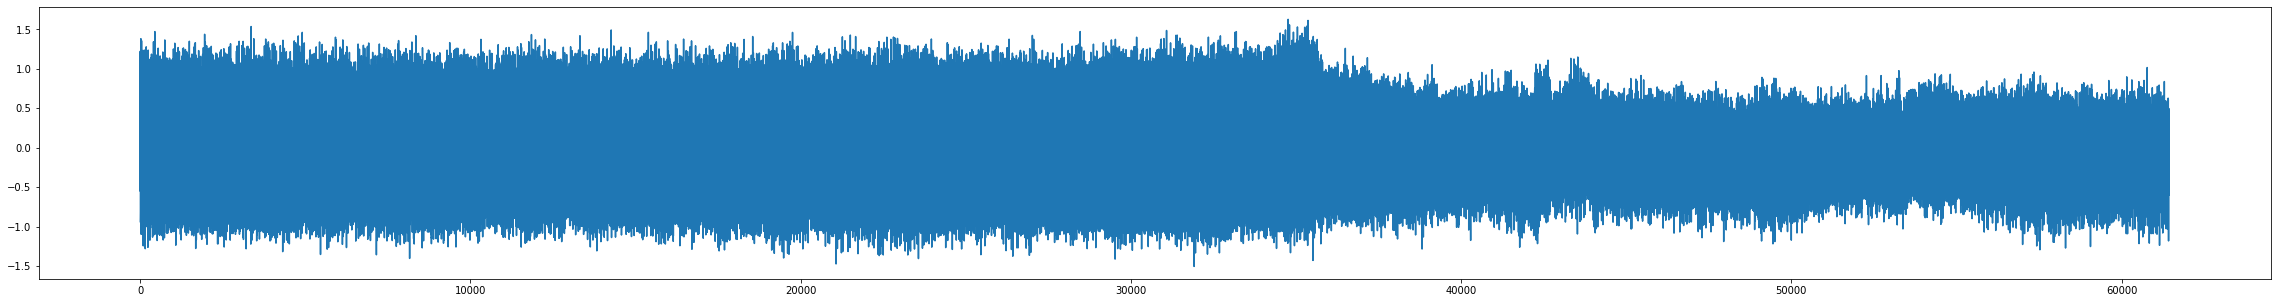

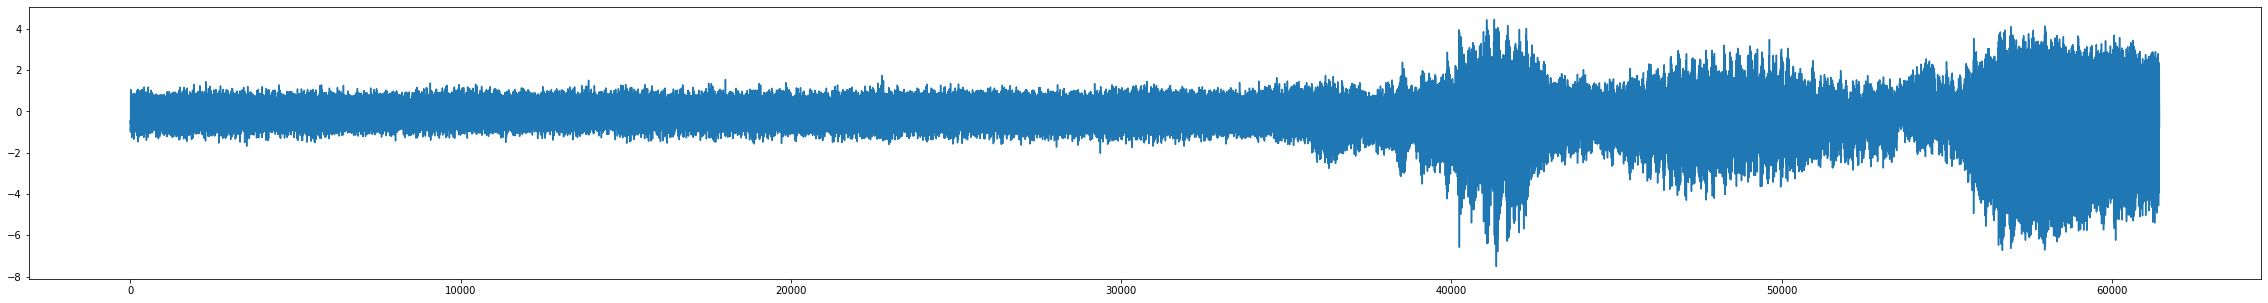

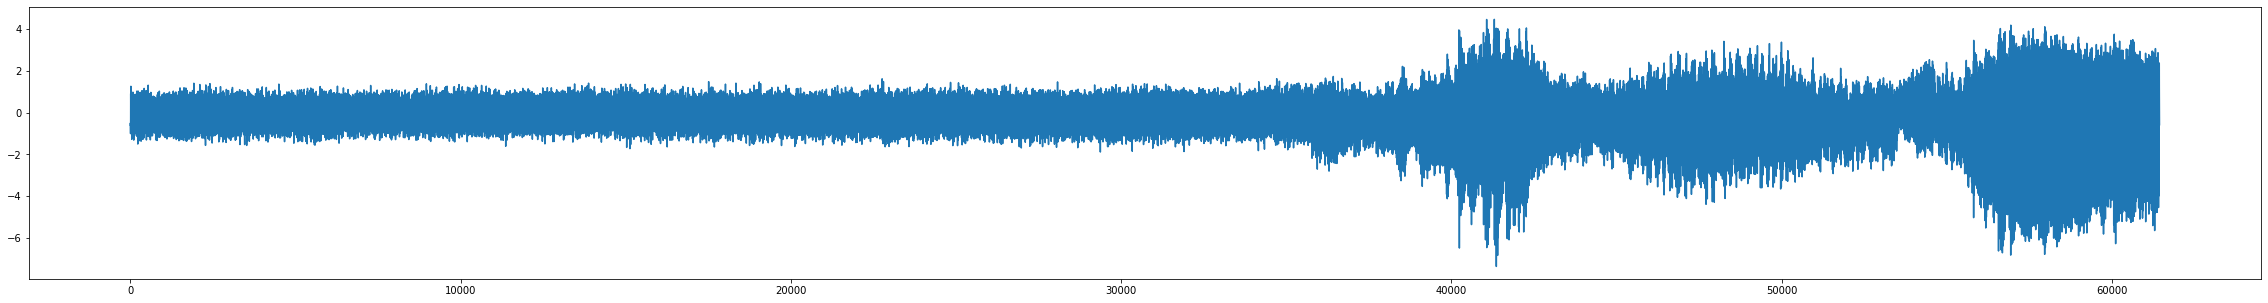

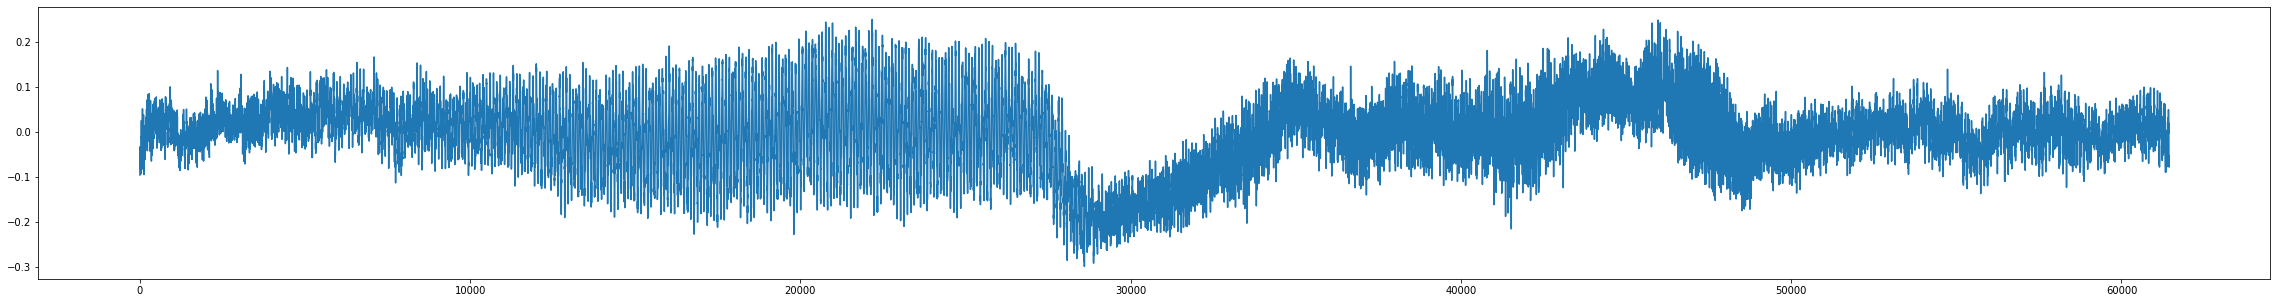

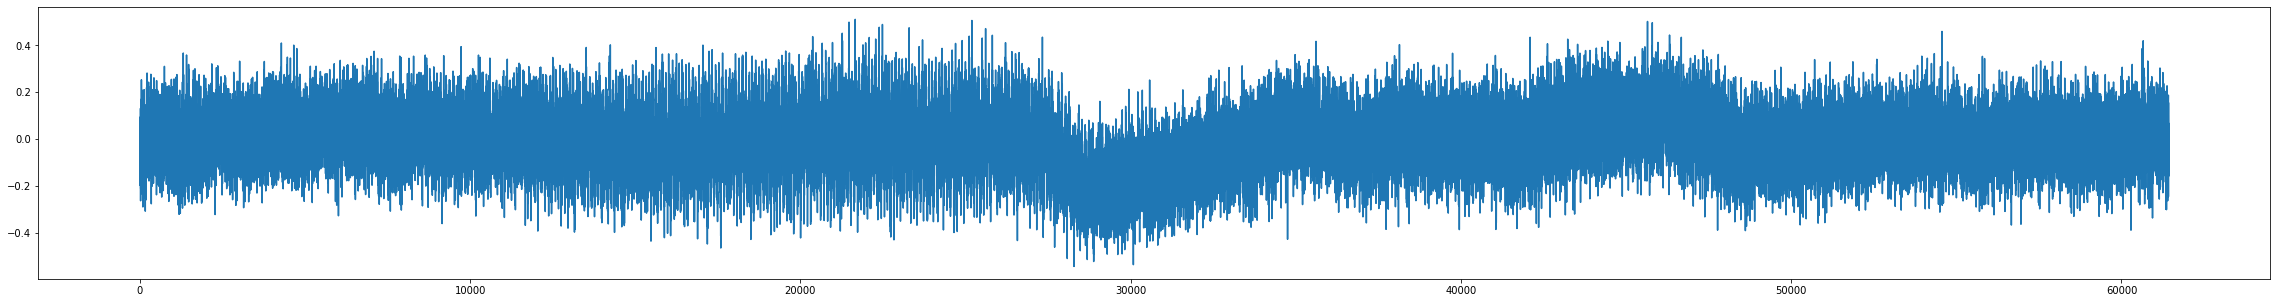

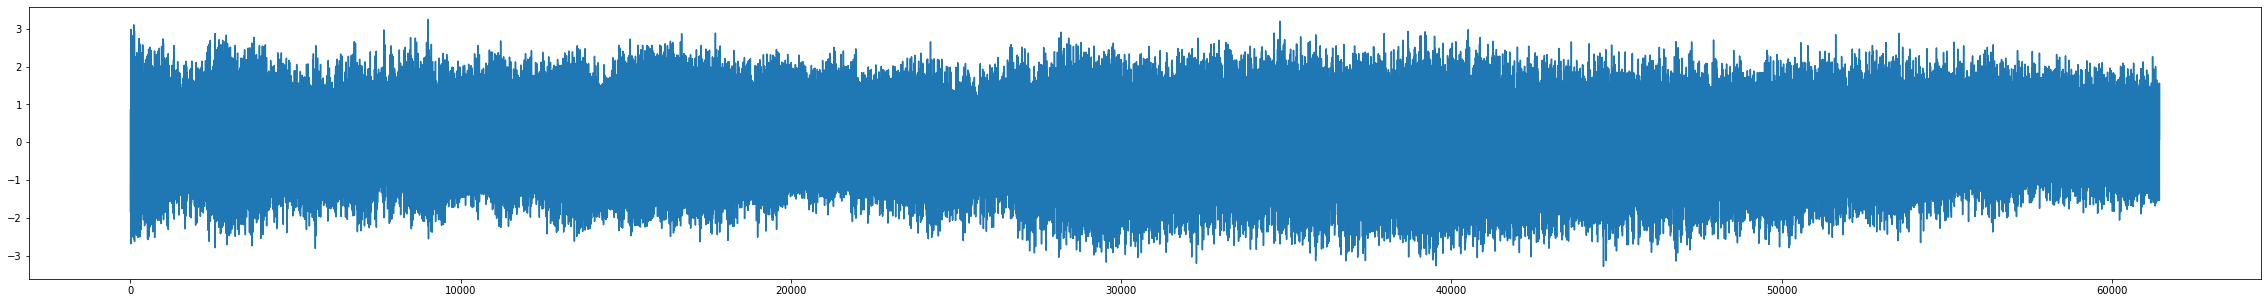

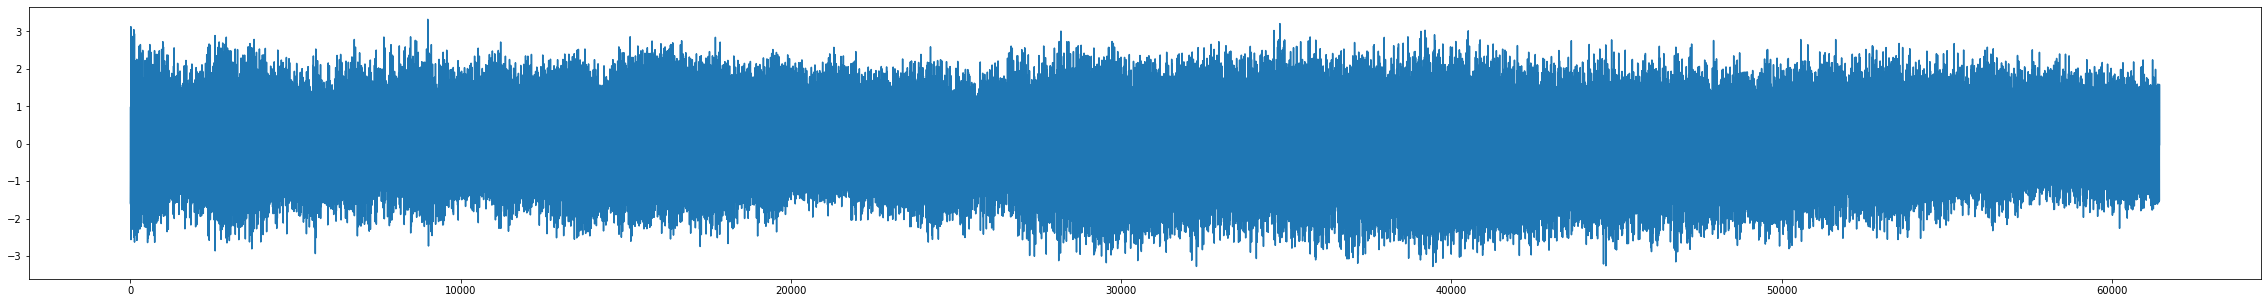

In [0]:
for i in [10, 589, 1000, 1120]:
  displayObservation(i, data)
  displayObservation(i, data_noise)

In [0]:
data_extend = np.concatenate((data, data_noise), axis=0)

In [0]:
data_prep = preproc(data_extend)
data_test_prep = preproc(data_test).fillna(500)

In [0]:
lof = LocalOutlierFactor(n_neighbors = 9, novelty = True, metric= 'euclidean')
lof.fit(data_prep)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='euclidean', metric_params=None, n_jobs=None,
                   n_neighbors=9, novelty=True, p=2)

In [0]:
scores = -lof.score_samples(data_test_prep)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_feat_sum.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.792596746882 (feat LOF10 extend noise) - 30/04 (22/48)

Score 0.790901899712 (feat LOF15 extend noise) - 30/04

Score 0.794456907313 (feat LOF9 extend noise) - 30/04

Score 0.794456907313 (feat LOF9 extend noise x2) - 30/04 (22/48)

Score 0.792162606449 (feat LOF11 extend noise x2) - 30/04

Score 0.792089992213 (feat LOF ext+ dev02) - 01/05

Score 0.792283115182 (featMed LOF ext+) - 01/05

Score 0.791450368942 (feat LOF roll) - 01/05

Score 0.707651995501 (feat LOF sum) - 01/05

Augmenting the data using noise gives slightly better results.

**PCA + LOF on extended data**

Now that I found that extended data adds some value, I tried a second time previous methods with extended data.

In [0]:
start_time = time.time()
pca_20 = PCA(n_components = 20)
data_reduced_20 = pca_20.fit_transform(data_extend)
print("{} seconds".format(round(time.time() - start_time,2)))

16.01 seconds


In [0]:
lof = LocalOutlierFactor(n_neighbors = 9, novelty = True, metric= 'euclidean')
lof.fit(data_reduced_20)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='euclidean', metric_params=None, n_jobs=None,
                   n_neighbors=9, novelty=True, p=2)

In [0]:
data_test_reduced = pca_20.fit_transform(data_test)

In [0]:
scores = -lof.score_samples(data_test_reduced)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_pca_lof_ext+.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.657376679397 (PCA LOF extend) - 01/05

**Spectral density**

As spectral density gives information about the frequency of the time serie, I thought this feature would be interesting to use.

In [0]:
def preproc(d):
  df = pd.DataFrame(d)
  x_autocorr = df.apply(lambda x: x.autocorr(lag=5), axis=1)
  x_var = df.apply(lambda x: np.var(x), axis=1)
  x_mean = df.apply(lambda x: np.mean(x), axis=1)
  x_min = df.apply(lambda x: np.min(x), axis=1)
  x_max = df.apply(lambda x: np.max(x), axis=1)
  _, Pxx_den = signal.periodogram(df, 10e3)
  df_Pxx_den = pd.DataFrame(Pxx_den)
  x_den = df_Pxx_den.apply(lambda x: np.sqrt(np.max(x)), axis=1)

  return pd.concat([x_autocorr, x_var, x_mean, x_max, x_den], axis=1)

In [0]:
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [data.shape[0],data.shape[1]])
data_extend = np.concatenate((data, data + noise), axis=0)

In [0]:
data_prep = preproc(data_extend)
data_test_prep = preproc(data_test).fillna(500)

In [0]:
lof = LocalOutlierFactor(n_neighbors = 9, novelty = True, metric= 'euclidean')
lof.fit(data_prep)
scores = -lof.score_samples(data_test_prep)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='euclidean', metric_params=None, n_jobs=None,
                   n_neighbors=9, novelty=True, p=2)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_featdens_lof_ext+.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.754571606907 (featDensity LOF ext+) - 01/05

**STL decomposition**

My idea in this part was to decompost the time serie in trend, season and residual. After doing so, I would train my models on the residuals since the time serie would not has noise coming from the season.

Unfortunately, I didn't manage to do so properly.

In [0]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

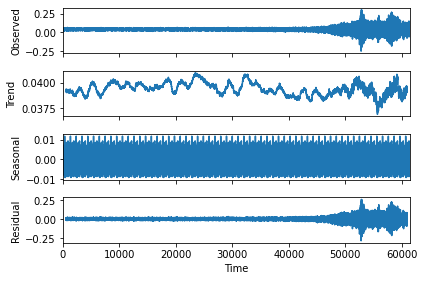

In [0]:
result1 = seasonal_decompose(data[0], freq=1024)
result1.plot()
pyplot.show()

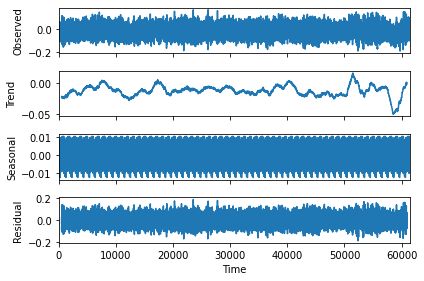

In [0]:
result2 = seasonal_decompose(data_test[562], freq=1024)
result2.plot()
pyplot.show()

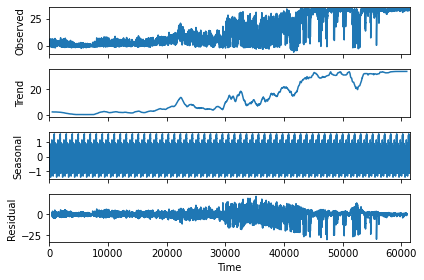

In [0]:
result3 = seasonal_decompose(data_test[225], freq=1024)
result3.plot()
pyplot.show()

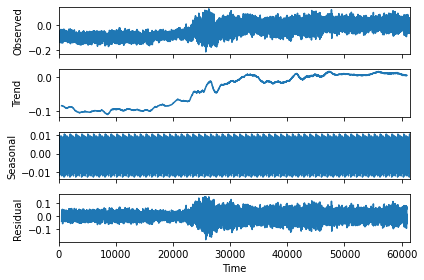

In [0]:
result4 = seasonal_decompose(data_test[2035], freq=1024)
result4.plot()
pyplot.show()

**TSFRESH feature extraction**

*tsfresh* is a package used to extract a large number of features from time series.

Here are the most significant features I tried out:

- Absolute sum of change:

$$\Sigma_{i=1}^{n-1} |x_{i+1}-x_i |$$

- c3:

"It was proposed in as a measure of non linearity in the time series."

$$\frac{1}{n-2 * lag}\Sigma_{i=1}^{n-2lag} x_{i+2 * lag} x_{i + lag} x_i$$

Schreiber, T. and Schmitz, A. (1997).
Discrimination power of measures for nonlinearity in a time series
PHYSICAL REVIEW E, VOLUME 55, NUMBER 5

- cid_ce:

"This function calculator is an estimate for a time series complexity (a more complex time series has more peaks, valleys etc.)."

$$\sqrt{\Sigma_{i=1}^{n-2*lag} (x_{i+1}-x_i )^2}$$


Batista, Gustavo EAPA, et al (2014).
CID: an efficient complexity-invariant distance for time series.
Data Mining and Knowledge Discovery 28.3 (2014): 634-669.

- symmetry_looking:

"Boolean variable denoting if the distribution of x looks symmetric."

$$|mean(X)-median(X)| < r*(max(X)-min(X))$$


<a name="mastering_feature_extraction">ref:mastering_feature_extraction</a>

In [0]:
!pip install tsfresh

In [0]:
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [data.shape[0], data.shape[1]])
data_extend = np.concatenate((data, data + noise), axis=0)

In [0]:
import tsfresh
from tsfresh.feature_extraction import feature_calculators as tsf_calc
from sklearn.preprocessing import StandardScaler

def standardize(s):
  return (s - np.mean(s))/np.std(s)

def preproc(d):
  df = pd.DataFrame(d)
  x_autocorr = df.apply(lambda x: x.autocorr(lag=5), axis=1)
  x_mean = df.apply(lambda x: np.mean(x), axis=1)
  x_max = df.apply(lambda x: np.max(x), axis=1)
  x_c3 = df.apply(lambda x: tsf_calc.c3(x,5), axis=1)
  x_cid = standardize(df.apply(lambda x: tsf_calc.cid_ce(x,False), axis=1))

  return pd.concat([x_autocorr, x_mean, x_max, x_c3, x_cid], axis=1)

In [0]:
data_prep = preproc(data_extend)
data_test_prep = preproc(data_test).fillna(500)

In [0]:
lof = LocalOutlierFactor(n_neighbors = 7, novelty = True, metric= 'euclidean')
lof.fit(data_prep)
scores = -lof.score_samples(data_test_prep)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_noise_15.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.823735894298 (feat abs_sum_ch std LOF) - 01/05 (15/49)

Score 0.842356038414 (feat abs_sum_ch std noise LOF) - 02/05 (7/49)

Score 0.850189106011 (featsf LOF7 noise) - 02/05 (5/49)

Score 0.835941265898 (featsf LOF5 noise) - 02/05

Score 0.838057893631 (squared LOF8 noise) - 02/05

Score 0.79200192814 (entropy LOF7 noise) - 02/05

Score 0.617730851471 (featStd LOF7 noise) - 02/05

Score 0.861909352714 (feat c3 LOF7 noise) - 02/05

Score 0.865061119557 (feat cid LOF7 noise) - 02/05 (4/49)

Score 0.865061119557 (feat mean_2nd LOF7 noise) - 02/05

Score 0.855658348474 (feat mean_2nd_std LOF7 noise) - 02/05

Score 0.863991990804 (feat asym LOF7 noise) - 02/05

Score 0.871448082366 (feat no var) - 03/05 (3/49)

Score 0.821016722904 (feat no autocorr) - 03/05

Score 0.663819261621 (above_mean LOF7) - 03/05

Score 0.701147613927 (mean_abs LOF7) - 03/05

Score 0.868089287701 (first_max LOF7) - 03/05

Score 0.8758080265 (no soc) - 03/05 (3/49)

Score 0.859919413648 (no c3) - 03/05

**Focus on quantile feature**

The use of quantiles may be relevant since there is an asymmetry in train/test distribution.

(array([   41.,   623.,  5139., 11749., 11885.,  9568., 11850.,  9529.,
          969.,    87.]),
 array([-1.726825, -1.392219, -1.057613, -0.723007, -0.388401, -0.053795,
         0.280811,  0.615417,  0.950023,  1.284629,  1.619235]),
 <a list of 10 Patch objects>)

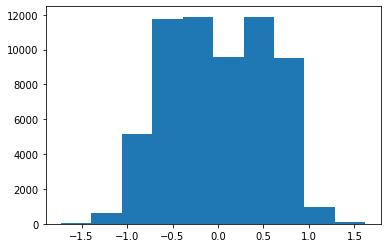

In [0]:
plt.hist(data[5])

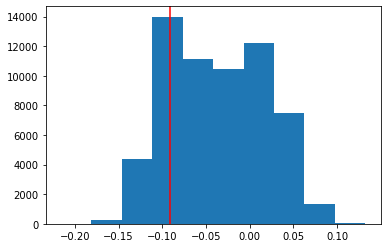

In [0]:
plt.hist(data_test[2035])
plt.axvline(np.quantile(data_test[2035],0.2),color='r')

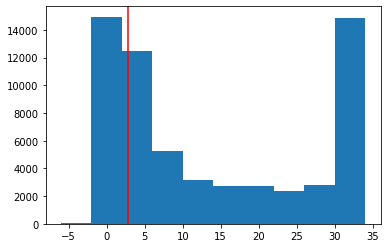

In [0]:
plt.hist(data_test[225])
plt.axvline(np.quantile(data_test[225],0.3),color='r')

However some test observations seem have a symmetric distribution, probably because the test set also have non-anomaly observations.

(array([   62.,   492.,  3183., 10577., 18206., 17251.,  8868.,  2377.,
          391.,    33.]),
 array([-0.188657 , -0.1528122, -0.1169674, -0.0811226, -0.0452778,
        -0.009433 ,  0.0264118,  0.0622566,  0.0981014,  0.1339462,
         0.169791 ]),
 <a list of 10 Patch objects>)

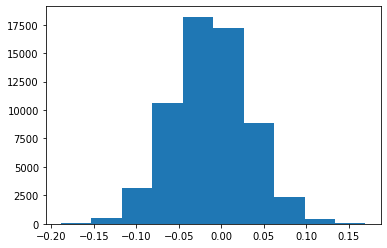

In [0]:
plt.hist(data_test[562])

**Test on Data Augmentation package**

*tsaug* is a package for data augmentation time series.

In [0]:
!pip install tsaug

In [0]:
import tsaug
a = tsaug.TimeWarp(n_speed_change=5, max_speed_ratio=2).augment(data[2])

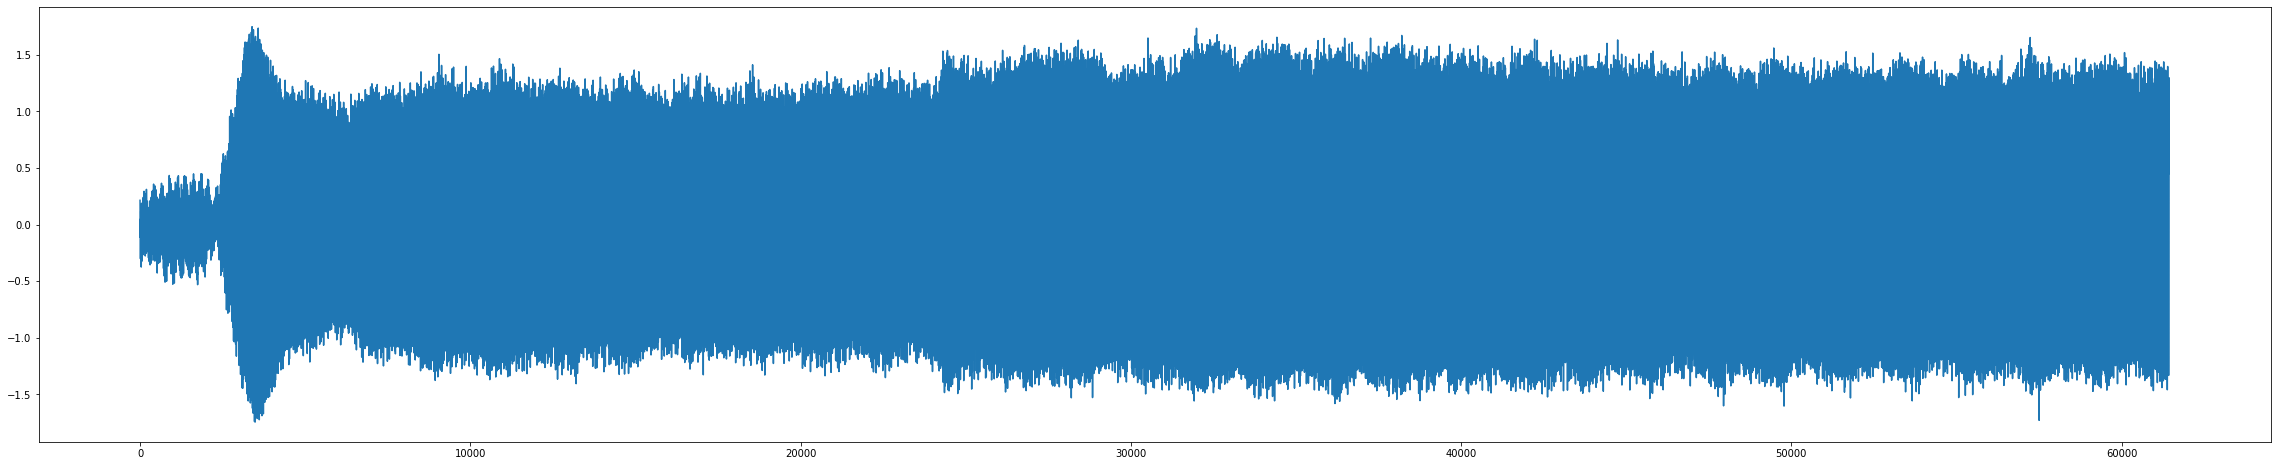

In [0]:
plt.figure(figsize=(40,8))
plt.plot(data[2])

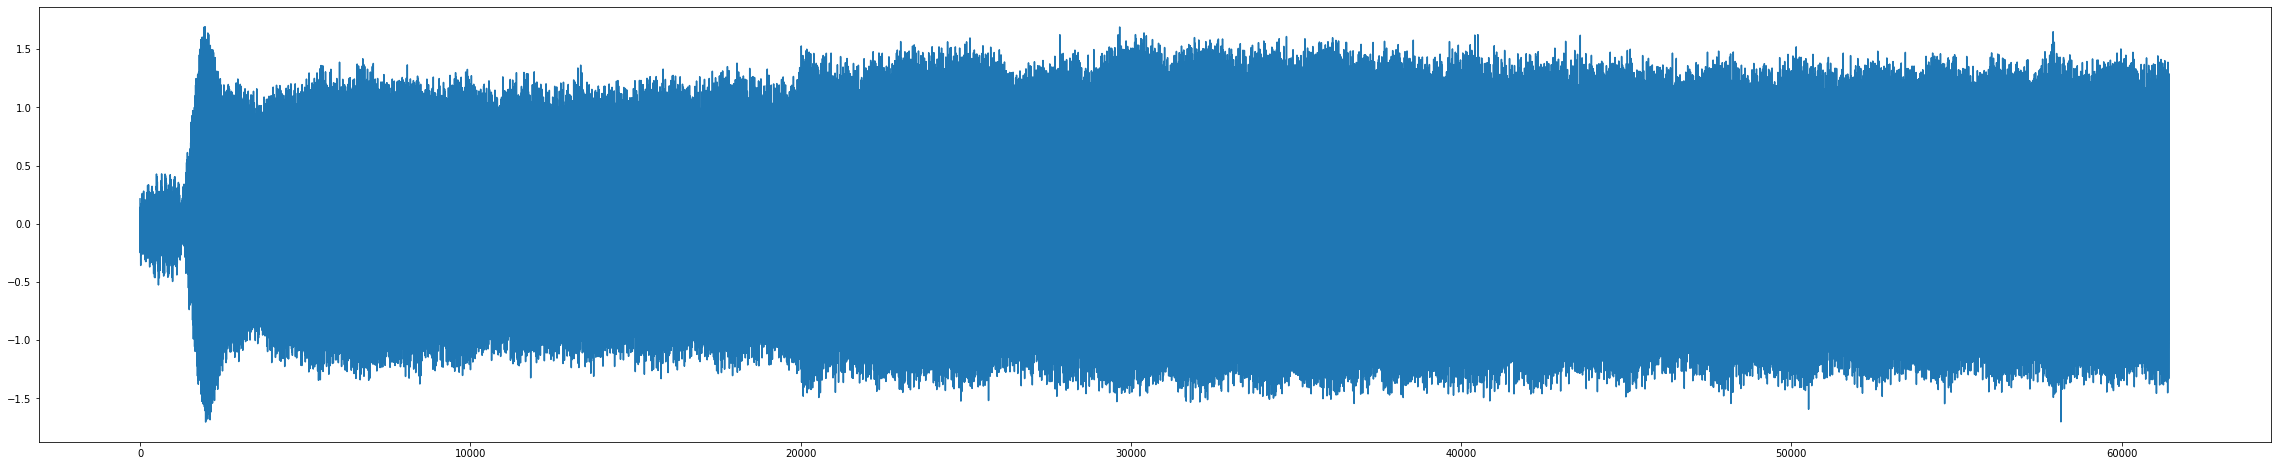

In [0]:
plt.figure(figsize=(40,8))
plt.plot(a)

In [0]:
data_time = np.zeros((500,data.shape[1]))
for i in range(500):
  data_time[i]=tsaug.TimeWarp(n_speed_change=5, max_speed_ratio=2).augment(data[i])

In [0]:
data_extend_time = np.concatenate((data_extend, data_time), axis=0)

It turned out that this data augmentation didn't improve the score.

**More feature engineering using binary variables**

I decided to introduce binary variables in order to spot outliers efficiently using a threshold. If a variable would be higher than a specific value, it is considered as outlier.

This method is relevant since LocalOutlierFactor uses the euclidean distance (in my configuration). Thus, using 0 for non outlier would not change the distance at all.

<a name="feature_extraction_binary">ref:feature_extraction_binary</a>

In [0]:
import tsfresh
from tsfresh.feature_extraction import feature_calculators as tsf_calc
from sklearn.preprocessing import StandardScaler

def standardize(s):
  return (s - np.mean(s))/np.std(s)

def preproc(d):
  df = pd.DataFrame(d)
  x_autocorr = df.apply(lambda x: x.autocorr(lag=5), axis=1)
  x_mean = df.apply(lambda x: np.mean(x), axis=1)
  x_max = df.apply(lambda x: np.max(x), axis=1)
  x_c3 = df.apply(lambda x: tsf_calc.c3(x,5), axis=1)
  x_cid = standardize(df.apply(lambda x: tsf_calc.cid_ce(x,False), axis=1))
  x_sym = df.apply(lambda x: 0 if tsf_calc.symmetry_looking(x,[{'r':0.0106}])[0][1] else 1, axis=1) # all observations that are strongly asymmetric

  # **** Below features have been tested but were not successful ****
  #x_lstd = df.apply(lambda x: 1 if (np.std(x) > (0.25 * (np.max(x) - np.min(x)))) else 0, axis=1) # all observations that are strongly asymmetric
  #x_line = df.apply(lambda x: 1 if (np.max(x)-np.min(x))==0 else 0, axis=1) # all observations that are lines
  #x_mm = df.apply(lambda x: 1 if (np.max(x)-np.min(x))>37 else 0, axis=1)
  #x_var = df.apply(lambda x: 1 if tsf_calc.variance_larger_than_standard_deviation(x) else 0, axis=1)
  #x_long = df.apply(lambda x: 1 if tsf_calc.longest_strike_above_mean(x)>4000 else 1, axis=1)
  # ******************************************************************

  return pd.concat([x_autocorr, x_mean, x_max, x_c3, x_cid, x_sym], axis=1)

The feature I found interesting is *longest_strike_below_mean* as it would be able to measure significantly different trend in the data.

In [0]:
longest_train_bw = pd.DataFrame(data).apply(lambda x: tsf_calc.longest_strike_below_mean(x), axis=1)
longest_test_bw = pd.DataFrame(data_test).apply(lambda x: tsf_calc.longest_strike_below_mean(x), axis=1)

In [0]:
print(np.max(longest_train_bw))
print(np.max(longest_test_bw))

5410
61440


As we can see, strike length are really different from train to test data. This could be a good indicator for an potential outlier.

In [0]:
data_prep = preproc(data_extend)
data_test_prep = preproc(data_test).fillna(500)

In [0]:
lof = LocalOutlierFactor(n_neighbors = 7, novelty = True, metric= 'euclidean')#, metric_params={'V':np.cov(data_prep.T)})
lof.fit(data_prep)
scores = -lof.score_samples(data_test_prep)

In [0]:
np.savetxt('/content/gdrive/My Drive/scores_long4000_std.csv', scores, fmt = '%1.6f', delimiter=',')

Score 0.824081970658 (change quantile std) - 03/05

Score 0.858362070031 (change quantile nostd) - 03/05

Score 0.869757870147 (change quantile (0-0.3)) - 03/05

Score 0.871370833179 (change quantile (0-0.05)) - 03/05

Score 0.870514912183 (change quantile 0-0.05 var) - 03/05

Score 0.871169985292 (change quantile 0.05-0.15 var) - 03/05

Score 0.868945208696 (data extend time) - 03/05

Score 0.854950745918 (first location max) - 03/05

Score 0.87201045645 (sym) - 03/05

Score 0.879817259322 (sym 1%) - 03/05 (5/49)

Score 0.879600961598 (max-min 30) - 03/05

Score 0.879817259322 (max-min 37) - 03/05

Score 0.843857762616 (sym 0.5%) - 03/05

Score 0.87201045645 (sym 15%) - 03/05

Score 0.869269655283 (longest7000) - 03/05

Score 0.859729380647 (longest100) - 03/05

Score 0.86625384701 (longestabove7000 below6000) - 03/05

Score 0.877822685305 (sym 0.9%) - 03/05

Score 0.880118531153 (sym 1.1%) - 03/05 (5/51)

Score  (sym 1.05%) - 03/05

Score 0.859250435685 (large std 10%) - 03/05

Score 0.881198474792 (sym 1.05%) - 03/05 (4/51)

Score 0.736506111956 (sym 1.05% no max) - 03/05

Score 0.8806 (sym 1.04%) - 03/05

<font color="green">Score  0.881281903914 (sym 1.06%) - 03/05 (4/51)</font>

Score 0.876677852349 (var>std) - 03/05